# PXD009019 Spectral Counting (SpC) Analysis with R and edgeR

## Phil Wilmarth, OHSU

### July 2019

## Sea lion urine proteomics

The data was from this publication:

> Neely, B.A., Prager, K.C., Bland, A.M., Fontaine, C., Gulland, F.M. and Janech, M.G., 2018. Proteomic Analysis of Urine from California Sea Lions (Zalophus californianus): a Resource for Urinary Biomarker Discovery. Journal of proteome research, 17(9), pp.3281-3291.

The data is in PRIDE with the PXD009019 identifier. There are 19 RAW files. The datasets are about 65K MS2 spectra per sample (single longer gradient LC runs). The data are high resolution MS1, HCD dissociation, and high resolution MS2 scans. Urine, like other biofluids, will have semi-tryptic peptides due to signal peptides, endogenous proteases, etc. 

The RAW files were processed with the Comet/PAWs pipeline using semi-tryptic searches with a wide parent mass tolerance. Oxidized Met was allowed as a variable modification. Since the publication came out, the sea lion genome has been sequenced and is available at NCBI. The publication used a database of two similar species in lieu of a species-specific database.  

There were 8 California sea lions as controls for healthy urine and urine from 11 _Leptospira interrogans_ infected sea lions.

## Objectives and overview

This notebook will demonstrate using Jupyter notebooks, R, and edgeR to perform a comparison of the control urine proteomes to the infected sea lion urine proteomes. The goal is to find which proteins are differentially expressed. 

The notebook will:
- load libraries and set up the R session
- load the proteomics result file
- do some exploratory data analysis of starting data
- load data into edgeR data structures
- normalize the data
- compute trended variances
- perform an exact test for differential expression (DE)
- visualize the test results
- collect results into table and write to a file

---

The goal here is to demonstrate edgeR **(Ref-1**) statistical testing that can be used for spectral counting **(Ref-2)** semi-quantitative experiments. The [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git) has some features for shotgun quantitation that we will be using. One is a protein grouping algorithm where highly homologous proteins (majority of peptides are shared with few unique peptides) are grouped together and the context for shared or unique peptides are updated accordingly. This extended parsimony logic is described in more detail [here](https://digitalcollections.ohsu.edu/concern/etds/c534fp149). The other feature is the splitting of shared peptide spectral counts based on relative unique peptide evidence.

> **1.** Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> **2.** Liu, H., Sadygov, R.G. and Yates, J.R., 2004. A model for random sampling and estimation of relative protein abundance in shotgun proteomics. Analytical chemistry, 76(14), pp.4193-4201.

---

## Load R libraries

In [18]:
library("tidyverse")
library("edgeR")
library("limma")
library("psych")
library("gridExtra")
library("scales")

## Data was prepped in Excel and exported to `QC_check_669x19.txt`

The PAW pipeline, like most proteomics summary tables, has a lot more information that we need for the statistical analysis. Selecting the relevant columns from a large table is not too hard to do in R. Row filtering can be trickier. Decoy protein sequences and common contaminants are easy to drop. Missing data and filtering out low abundance data can be trickier.

The situation here needs to also allow for proteins that are in only one condition. One way to handle that is to require a minimum average spectral count across the 19 samples of 2.5. If we have expression in one condition of 5 (a level that is well above the minimum detection of 1 or 2) and nothing in the other condition, we will hit the average of 2.5. We demonstrated that this cutoff value is a good choice for this data in the `PXD009019_average_missing` notebook. We did the table sorting and filtering in Excel and collected the relevant count columns for the 669 proteins into a separate data file. We will find zero values and replaced them with a count of 0.25 after loading in the data. We explored the data for odd samples and outlier characteristics in the `PXD009019_QC_check` notebook. We decided that three of the lepto samples should be excluded. This will give us 669 proteins for 8 control samples and 8 lepto samples that we can test.

### Read in the data

The data exported in the `QC_check_669x19.txt` file excluded contaminants, decoys, and any proteins with an average SpC of less than 2.5. We will read that data in and separate the accessions from the count data, replace any zeros with 0.25 count values, and drop three lepto samples.

In [19]:
# read in the prepped data
paw_spc <- read_tsv("QC_check_669x19.txt")

# save accessions in vector and remove from data table
accession <- paw_spc$Accession
paw_spc <- select(paw_spc, -Accession)

# replace zeros with 0.25
paw_spc[paw_spc == 0] <- 0.25

# In a spearate notebook, we decided to exclude 3 lepto samples (2, 6, and 16)
paw_spc <- paw_spc[c(-10, -14, -18)]

head(paw_spc)
nrow(paw_spc)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character()
)
See spec(...) for full column specifications.


Control-08 Control-09 Control-10 Control-11 Control-12 Control-18 Control-19
1 1083.5     652.0      545.3      524.3      465.4      434.5      1142.5    
2  354.0     183.0      130.0       73.0       64.0       84.0       355.0    
3  192.0     109.0      206.0       88.0      154.0      173.0       314.0    
4  282.0     150.9      146.9       89.0       75.0       75.0       150.0    
5  131.0     102.0       17.0       25.0       21.0       40.0        49.0    
6  114.0     104.0       84.0       24.0       24.0       70.0        56.0    
  Control-20 Lepto-01 Lepto-03 Lepto-04 Lepto-05 Lepto-13 Lepto-14 Lepto-15
1 877.1      625.4    498.5    625.3    1311.6   1201.8   946.1    1002.8  
2  20.0      239.0    130.0    191.0     414.0    337.0   244.0     360.0  
3 455.0      166.0    251.0    354.0     160.0    186.0   280.0     154.0  
4 203.0      168.0     90.0    112.0     271.0    231.8   201.0     169.0  
5 112.0      127.0    105.0    151.0     336.0    169.0   126.0     291.0  
6 151.0      214.0    395.0    545.0     307.0     82.0   430.0     297.0  
  Lepto-17
1 1206.6  
2  440.0  
3  197.0  
4  217.0  
5  366.0  
6  236.0

[1] 669

### See what starting data looks like

SL Factors:
 Control-08 -> 1.088639
 Control-09 -> 1.099253
 Control-10 -> 1.464003
 Control-11 -> 1.425923
 Control-12 -> 1.097747
 Control-18 -> 1.156900
 Control-19 -> 1.072126
 Control-20 -> 1.006657
 Lepto-01 -> 0.858368
 Lepto-03 -> 0.758202
 Lepto-04 -> 0.906200
 Lepto-05 -> 0.819600
 Lepto-13 -> 0.829421
 Lepto-14 -> 0.823106
 Lepto-15 -> 1.095273
 Lepto-17 -> 1.058435


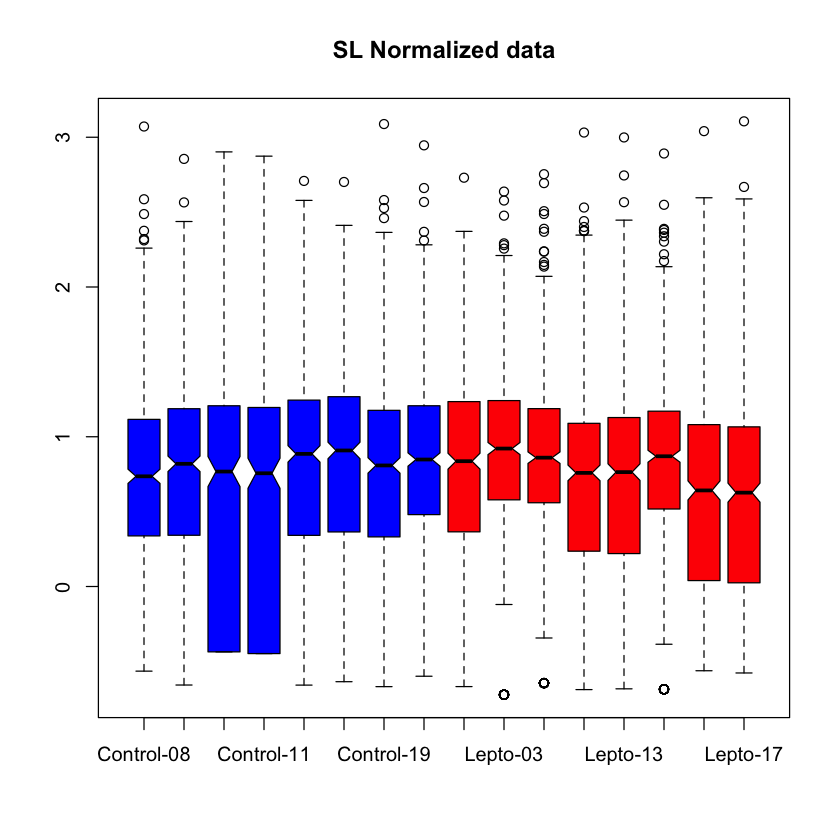

In [20]:
# function for simple normalization
SL_Norm <- function(df, color = NULL, plot = TRUE) {
    # This makes each channel sum to the average grand total
        # df - data frame of TMT intensities
        # returns a new data frame with normalized values
    
    # compute scaling factors to make colsums match the average sum
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    cat("SL Factors:\n", sprintf("%-5s -> %f\n", colnames(df), norm_facs))
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_sl), col = color, notch = TRUE, main = "SL Normalized data")
    }
    df_sl
}

# normalize the data before plotting
color <- c(rep('blue', 8), rep('red', 8))
paw_sl <- SL_Norm(paw_spc, color)

### Some samples have low SpC count tails

We have filtered out proteins with too few counts to be reliably quantified (keeping about 670 out of 2300 protein identifications). Despite that, we do have two control samples that have a lot of small SpC values. The three lepto sample we have excluded were even worse.  

### Check Control and lepto sample similarities

To get a sense of the data characteristics, we will compare the 8 control samples to each other, and do the same for the 8 lepto samples. Multi-panel scatter plots are a nice method for exploratory data analysis. We will try linear and log scales. 

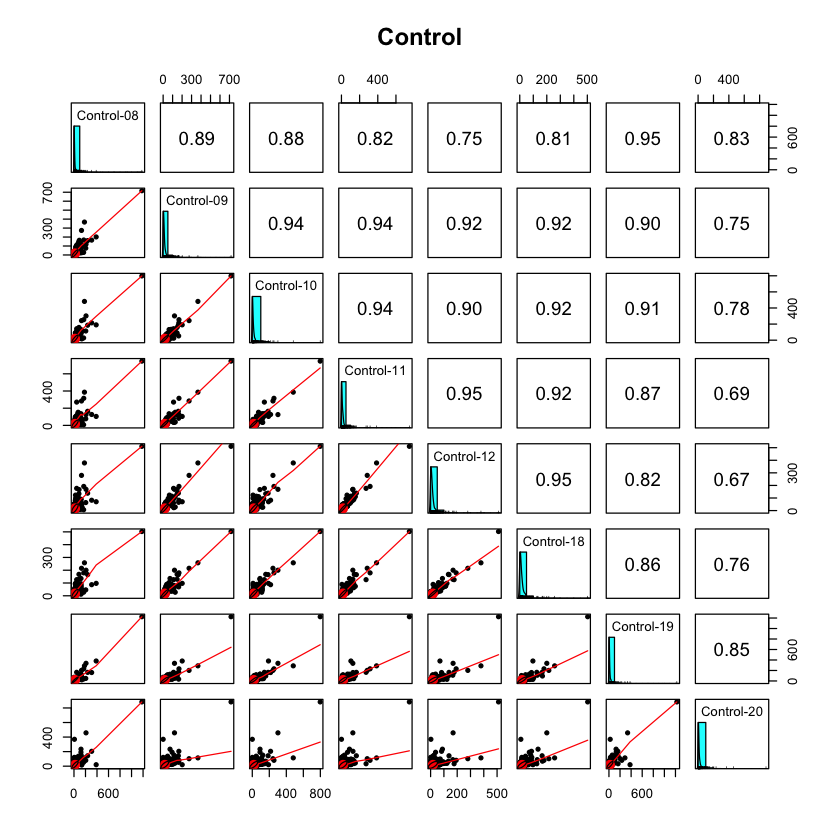

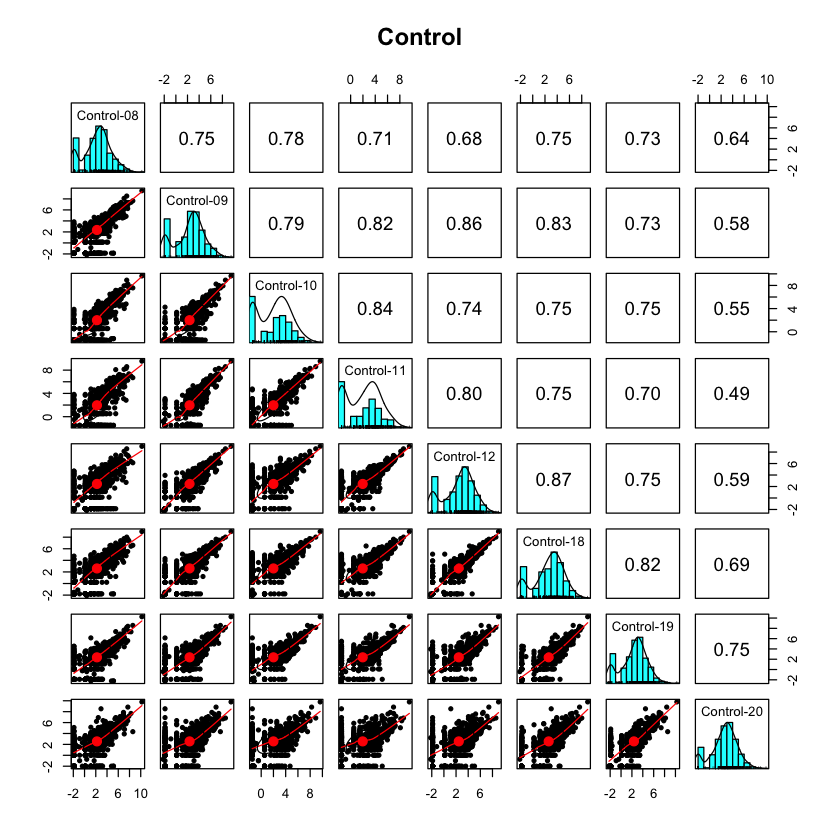

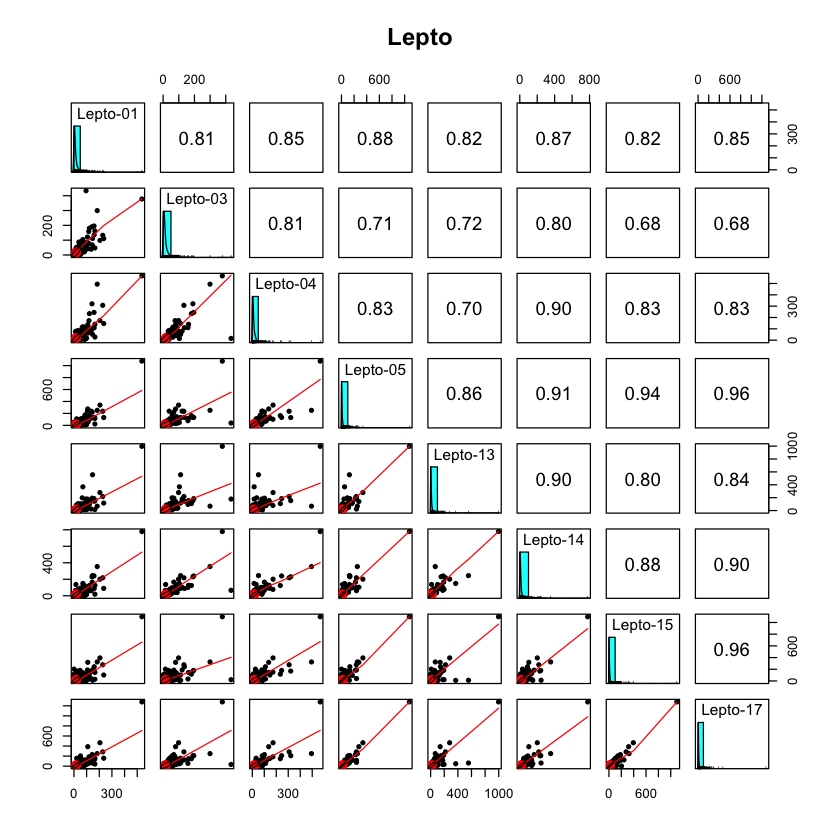

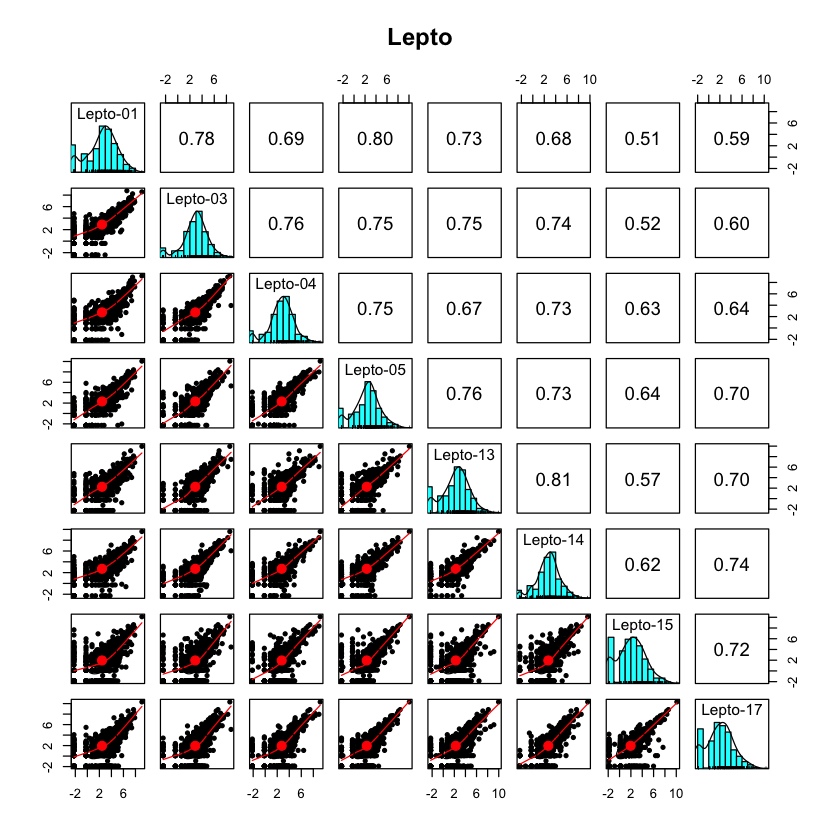

In [21]:
# shortcuts for the cell types
C <- 1:8
L <- 9:16

pairs.panels(paw_sl[C], main = "Control")
pairs.panels(log2(paw_sl[C]), main = "Control")
pairs.panels(paw_sl[L], main = "Lepto")
pairs.panels(log2(paw_sl[L]), main = "Lepto")

### Spectral counting is not real precise
The sample-to-sample consistency is okay for spectral counting data. There are some low abundance proteins in each sample that are not consistently detected (points along the axes). Interestingly, the correlation coefficients depend on whether the data is linear or log scale. 

---

## We can get started with edgeR

We will use the counts and accessions that we created in R above from the main summary file and load data into some edgeR data structures. We will run the built-in TMM normalization **(Ref-3)** and see if the samples have any structure in a clustering plot.

> **3.** Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

In [22]:
# load the data into edgeR data structures
# group labels need to be factors
group <- c(rep("Control", 8), rep("Lepto", 8))
y <- DGEList(counts = paw_spc, group = group, genes = accession)

# run the TMM normalization (and library size corrections)
y <- calcNormFactors(y)

# check normalizations
y$samples

group   lib.size norm.factors
Control-08 Control 10491.80 0.8984815   
Control-09 Control 10390.50 1.1414117   
Control-10 Control  7801.75 0.9145459   
Control-11 Control  8010.10 0.9431195   
Control-12 Control 10404.75 1.2761884   
Control-18 Control  9872.75 1.2443434   
Control-19 Control 10653.40 1.0171370   
Control-20 Control 11346.25 1.0343960   
Lepto-01   Lepto   13306.40 1.0800362   
Lepto-03   Lepto   15064.30 1.2022557   
Lepto-04   Lepto   12604.05 1.1326725   
Lepto-05   Lepto   13935.80 0.9681685   
Lepto-13   Lepto   13770.80 0.9027288   
Lepto-14   Lepto   13876.45 1.0429745   
Lepto-15   Lepto   10428.25 0.7260486   
Lepto-17   Lepto   10791.20 0.6951330

## Get the TMM normalized data out of edgeR

EdgeR uses the normalization factors as offsets in its modeling. The normalized data values have to be computed.

Overall Factors (lib.size+TMM):
 Control-08 -> 1.211643
 Control-09 -> 0.963064
 Control-10 -> 1.600798
 Control-11 -> 1.511922
 Control-12 -> 0.860176
 Control-18 -> 0.929727
 Control-19 -> 1.054062
 Control-20 -> 0.973184
 Lepto-01 -> 0.794758
 Lepto-03 -> 0.630650
 Lepto-04 -> 0.800054
 Lepto-05 -> 0.846547
 Lepto-13 -> 0.918793
 Lepto-14 -> 0.789191
 Lepto-15 -> 1.508540
 Lepto-17 -> 1.522637


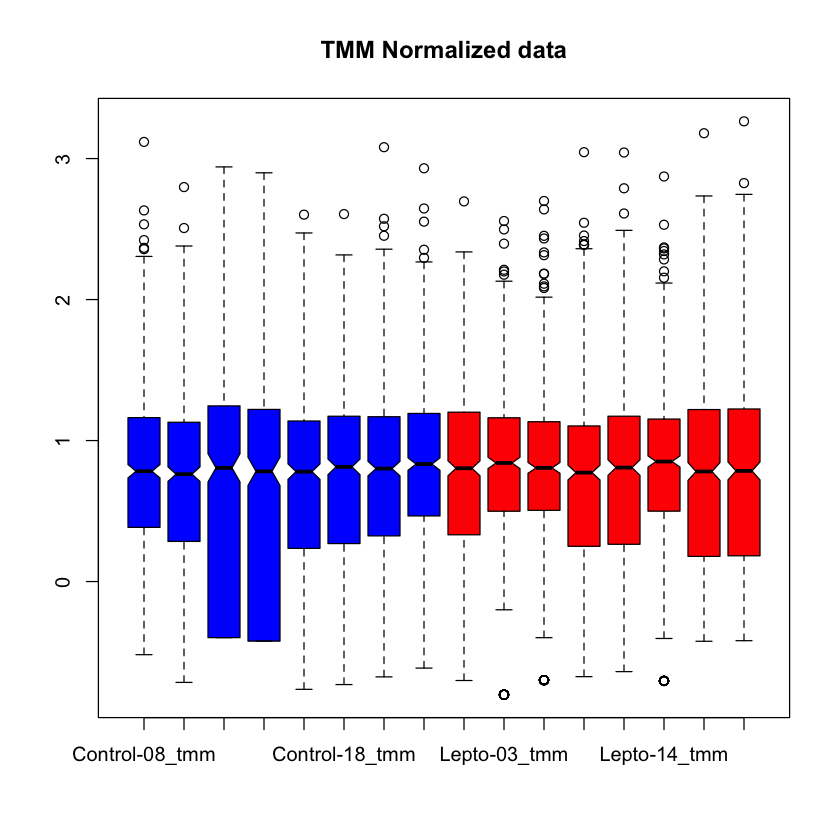

In [23]:
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    df_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(df_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    df_tmm
}

paw_spc_tmm <- apply_tmm_factors(y, color)

## Check that samples cluster by condition

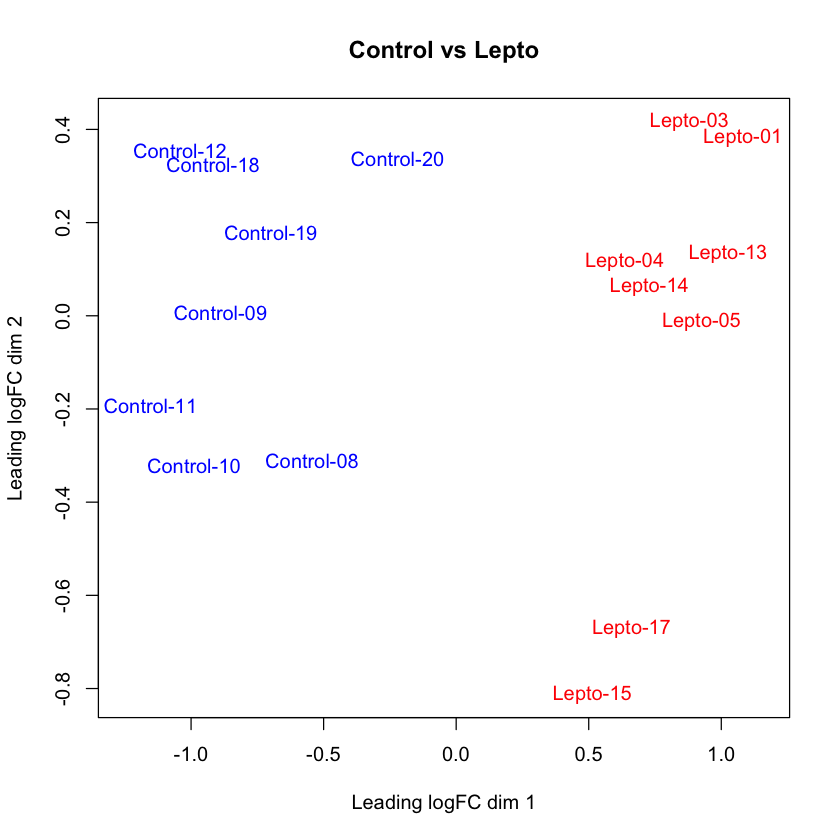

In [24]:
# check clustering
plotMDS(y, col = color, main = "Control vs Lepto")

## Clustering has left-to-right separation between Control and Lepto samples

The overall normalization factors (library size plus TMM factors) moved the median values a bit closer between the samples. The control samples clearly separate from the lepto samples. 

## Can also see how normalization affected CV distributions

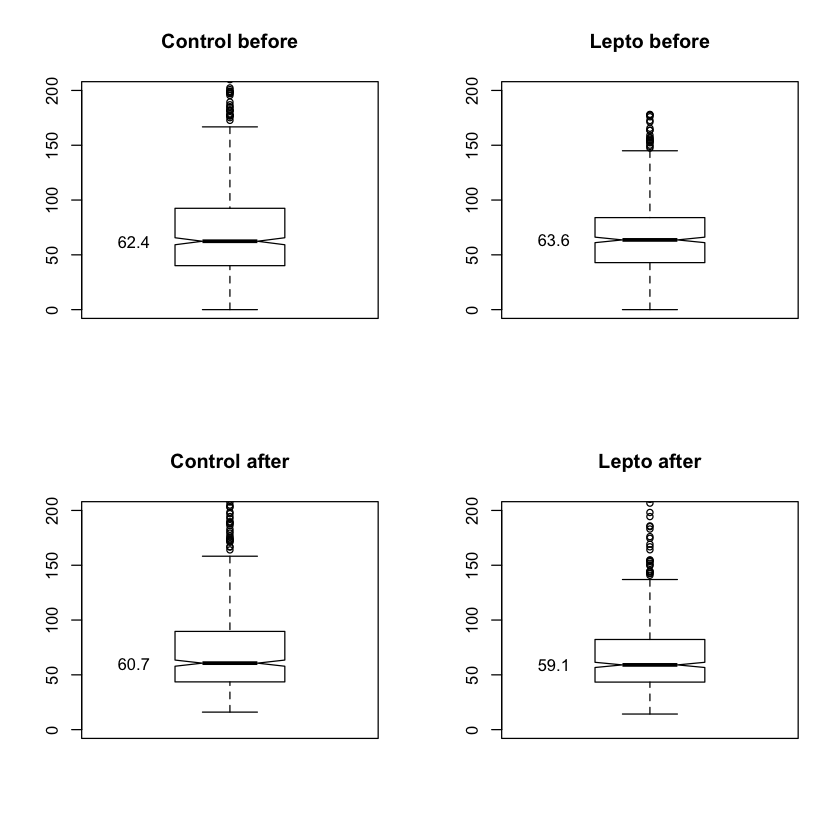

In [25]:
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

# see what effect TMM had on CV distributions
par(mfrow = c(2, 2))
labeled_boxplot(paw_spc[C], 200, "Control before")
labeled_boxplot(paw_spc[L], 200, "Lepto before")
labeled_boxplot(paw_spc_tmm[C], 200, "Control after")
labeled_boxplot(paw_spc_tmm[L], 200, "Lepto after")
par(mfrow = c(1, 1))

## CVs are not improved too much

The CVs in spectral counting are not great, but we might still have some larger differences in relative expression levels so we could still see DE candidates.

## Compute dispersion and exact test results

We will do a basic exact test in edgeR comparing control to lepto samples. We need to get trended dispersion first.

Design matrix not provided. Switch to the classic mode.


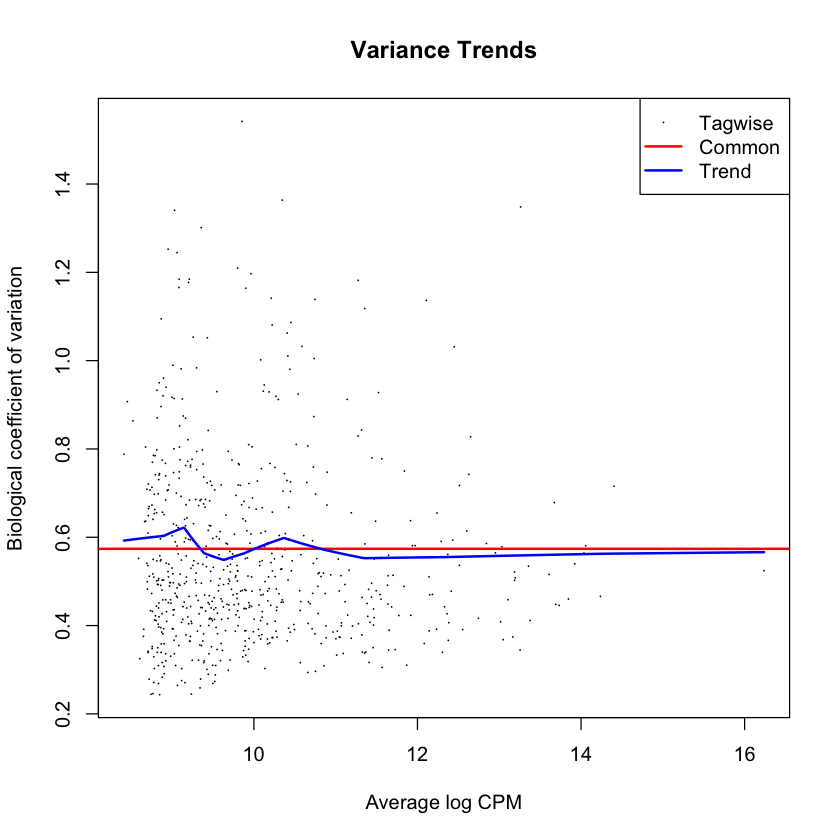

In [26]:
y <- estimateDisp(y)
plotBCV(y, main = "Variance Trends")

## See how many DE candidates we have

The reference state in edgeR is the second condition so **up** is increased expression in lepto samples and **down** is increased expression in the control samples.

In [27]:
et <- exactTest(y, pair = c("Control", "Lepto"))
topTags(et, n = 20)$table
tt <- topTags(et, n = Inf, sort.by = "none")$table
summary(decideTests(et, p.value = 0.05)) # usually use 0.10 for p-value

genes                 logFC     logCPM    PValue       FDR         
50  XP_027445216.1 (+2)   -5.062132 12.331482 2.163487e-31 1.447373e-28
134 XP_027426274.1         4.103383 10.664229 1.557185e-20 5.208784e-18
66  XP_027449689.1         3.903079 11.553559 1.990817e-19 4.439522e-17
198 XP_027472262.1         4.172232 10.166038 2.800244e-19 4.683408e-17
40  XP_027434694.1         2.941748 12.233234 1.746720e-18 2.337112e-16
378 XP_027440857.1 (+1)   -5.449760  9.693041 3.865052e-17 4.309533e-15
254 XP_027441032.1         3.797300  9.893257 5.075459e-16 4.850688e-14
496 XP_027465860.1        -4.027573  9.235795 1.492711e-15 1.248280e-13
270 XP_027462990.1        -3.736366 10.082182 2.224461e-15 1.602768e-13
61  XP_027473142.1        -4.173086 11.971005 2.395767e-15 1.602768e-13
517 XP_027438758.1 (+1)   -4.827581  9.223535 3.418185e-15 2.078878e-13
336 XP_027475258.1 (+1)   -4.114033  9.781772 4.630052e-15 2.581254e-13
77  XP_027451349.1        -3.447081 11.701994 1.144451e-14 5.642301e-13
445 XP_027472864.1        -5.084335  9.409092 1.180751e-14 5.642301e-13
203 XP_027482195.1         4.133935 10.167954 2.285040e-14 1.019128e-12
307 XP_027436133.1         4.968800  9.779577 6.087177e-14 2.545201e-12
89  XP_027455736.1_family  2.719415 11.278496 7.408211e-14 2.915349e-12
379 XP_027468270.1         3.510420  9.441959 9.058602e-14 3.366781e-12
56  XP_027423360.1        -2.876028 12.150441 1.648646e-13 5.804971e-12
345 XP_027479621.1        -4.353848  9.800317 2.940829e-13 9.837074e-12

       Lepto-Control
Down             193
NotSig           259
Up               217

## Quite a few candidates that are balanced between up and down

**NOTE:** Most normalization algorithms assume that the majority of proteins will not be differentially expressed (they all attempt to make something that should be the same end up being more "the same"). The TMM method in edgeR also works on that assumption. We have 259 unchanged proteins out of 669. This is quite a bit less than a majority of the proteins. The TMM results looked okay in the boxplots and clustering, but we should always keep these things in mind. 

Even without a sequenced genome, the publication reported about 2700 protein identifications. With the new database, Comet/PAW had about 2300 protein identifications (2 peptides per protein), excluding contaminants. A minimum average SpC of 2.5 or greater was required for proteins to be considered as quantifiable. There were 669 proteins that could be tested with edgeR. Despite the reduced number of testable proteins, there are 410 DE candidates, with a balanced split between up and down regulated candidates. The publication reported 316 candidates.

## We need to reformat and visualize DE results

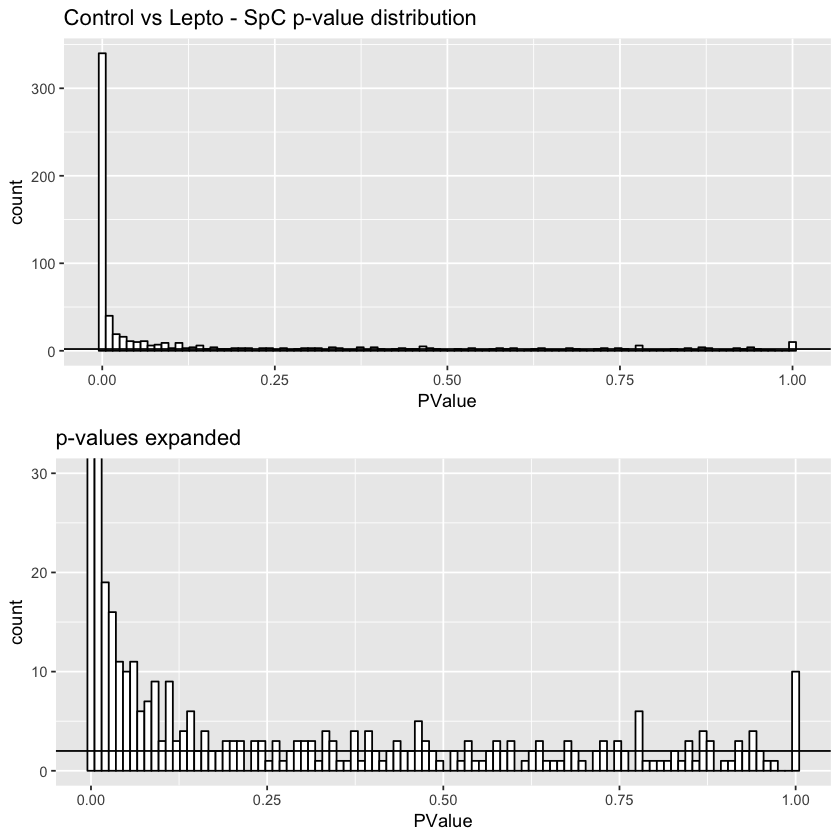

In [28]:
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# get the results summary
results <- collect_results(paw_spc_tmm, tt, C, "Control", L, "Lepto")

pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# check the p-value distribution
pvalue_plots(results, 30, "Control vs Lepto - SpC")

## P-value distribution looks okay

We have a flat distribution at larger p-values and a spike at low p-values. We can see what the fold changes look like for the different levels of DE candidates and count candidates. The small spike at 1.0 is typical when we have small, discrete values.

We can count the candidates with an FDR less than 0.01 (high), between 0.05 and 0.01 (medium), between 0.10 and 0.05 (low), or greater than 0.10 (no). We can plot distributions of log2 fold-changes by category.

candidate n  
1 high      340
2 med        70
3 low        39
4 no        220

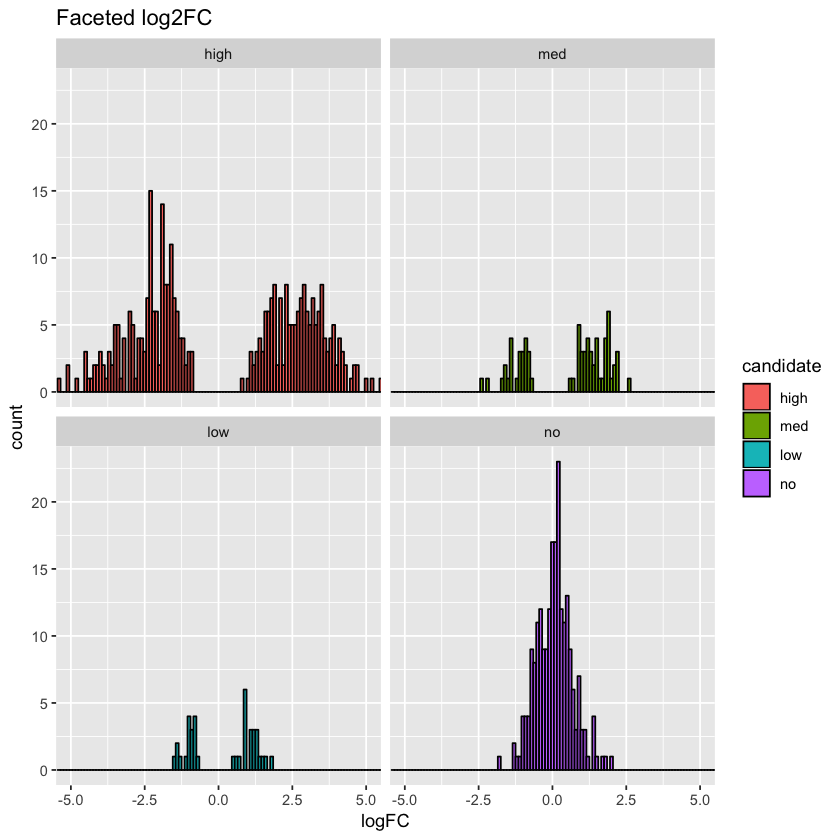

In [29]:
log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# make log2FC plots
log2FC_plots(results, 5, "Faceted log2FC")

# see how many candidates are in each category
results %>% count(candidate)

### We need to visualize the DE candidates (and non-candidates)

We will make:
- MA plots
- Scatter plots
- A volcano plot

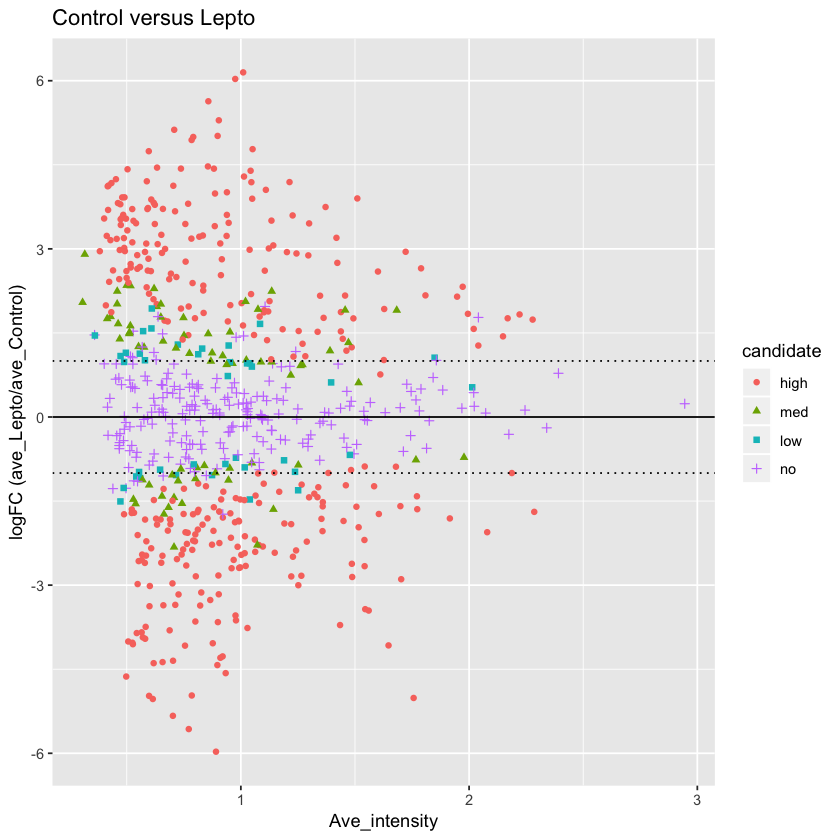

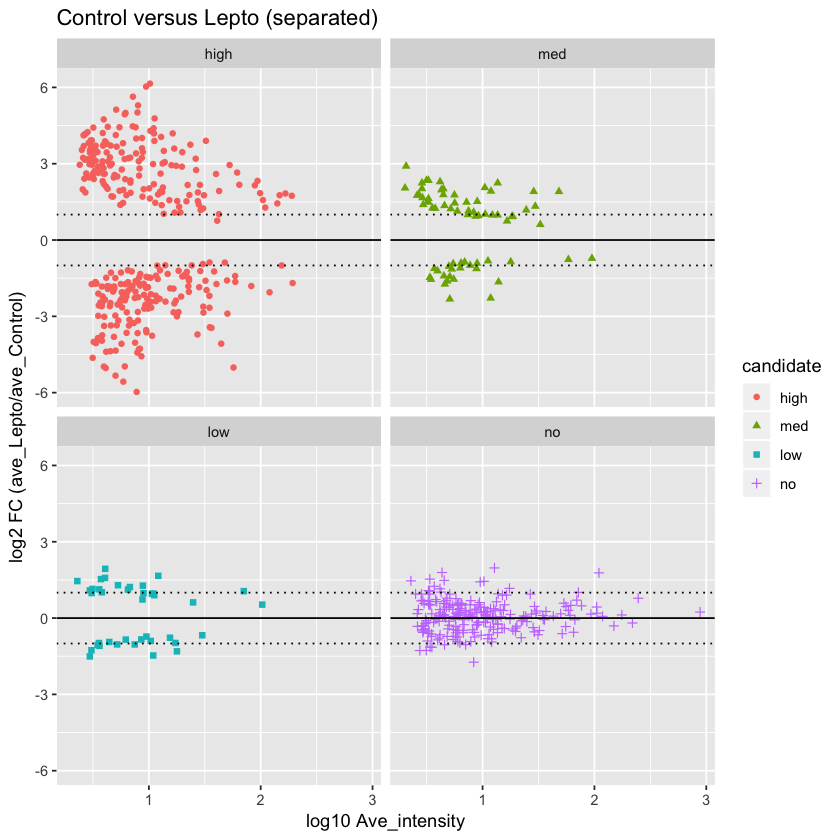

In [30]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# make MA plots
MA_plots(results, "ave_Control", "ave_Lepto", "Control versus Lepto")

## edgeR robustly models the wider dispersion at low spectral counts

---

# Important Sidebar

The spectral count values have been maintained in their natural measurement scale. That means that they are actual counts that have a Poisson distribution. EdgeR models that correctly so that the large uncertainty in small count numbers does not result in large numbers of false positive DE candidates. 

There are other commonly used transformations of spectral count data where this is not the case. Samples can be normalized to have all counts sum up to one by dividing each column by its total. That makes the measurement values be small fractions between 0.0 and 1.0. Taking logs of counts would also alter the natural measurement scale and change the mean-variance relationship. There can also be protein length correction (dividing by length or number of theoretical peptides) of counts to make relative abundances more like molar concentrations instead of weight percentages. Those have the effect of somewhat local scrambling of abundances and it disrupts the smooth dispersion trend making trended variance estimates less effective.

The bottom line is that just about anything you would do transformation-wise to spectral counts will hurt the data analysis. This is also likely true in other quantitative measures beside spectral counting. Determining a natural measurement scale is very important for data modeling. Do not arbitrarily transform data!

---

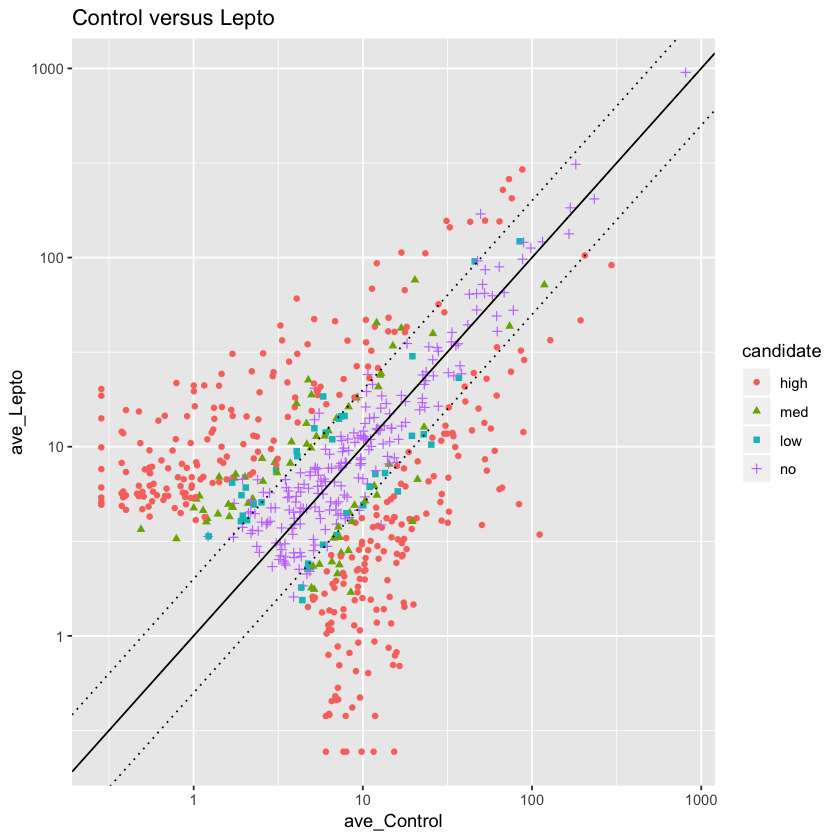

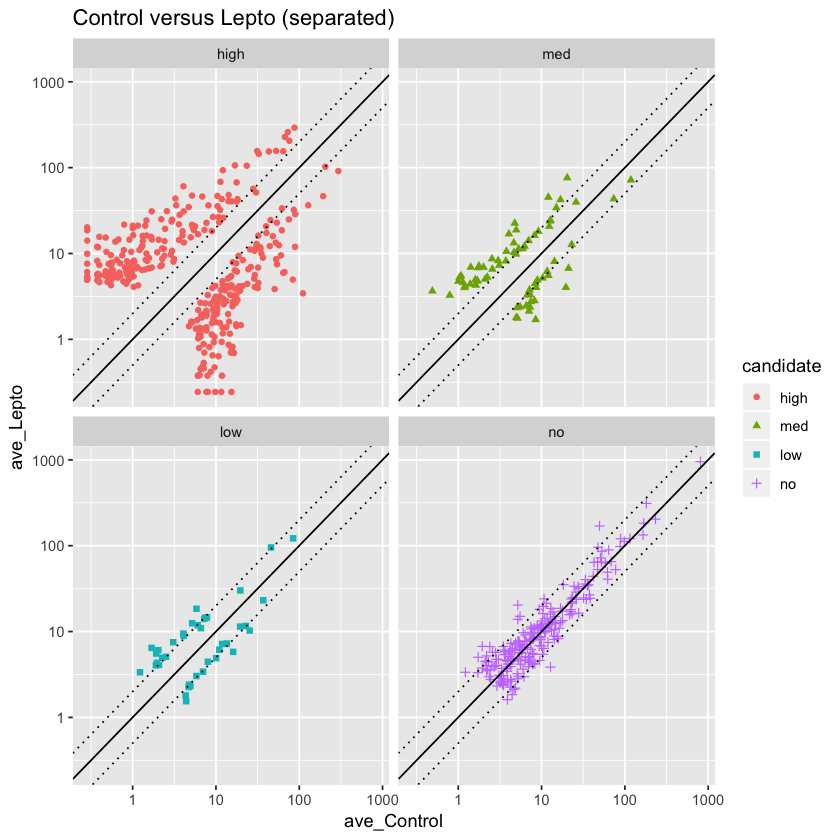

In [31]:
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# make scatter plots
scatter_plots(results, "ave_Control", "ave_Lepto", "Control versus Lepto")

## We see the discrete nature of small spectral count values

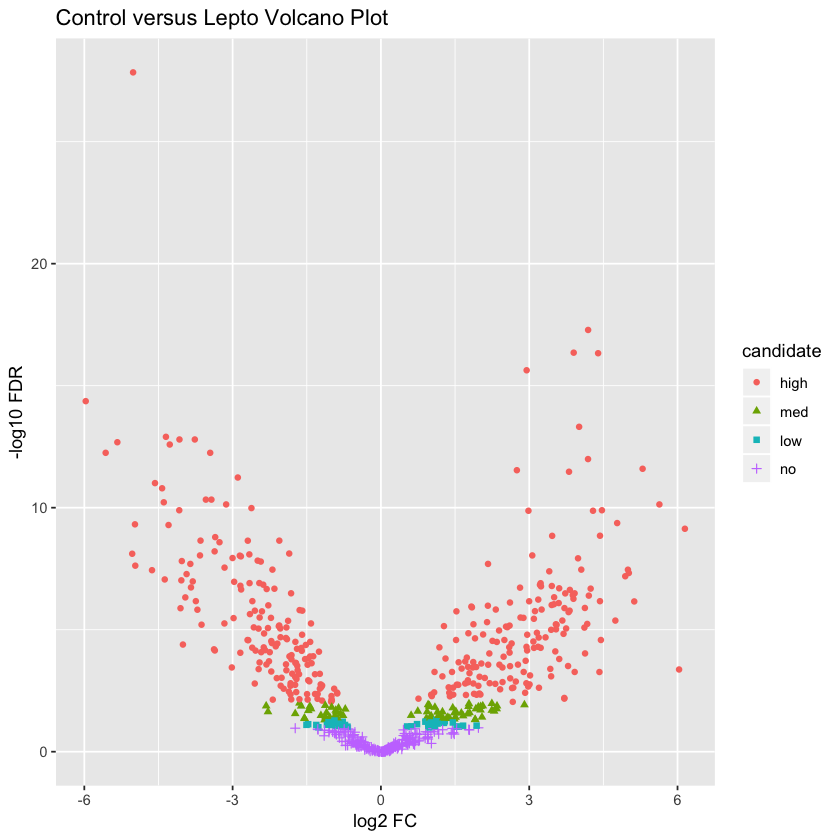

In [32]:
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# make a volcano plot
volcano_plot(results, "ave_Control", "ave_Lepto", "Control versus Lepto")

## The DE candidates look convincing

Let's look at some individual protein data. We will plot the top 50 up regulated and the top 50 down regulated proteins (about a quarter of the DE candidates).

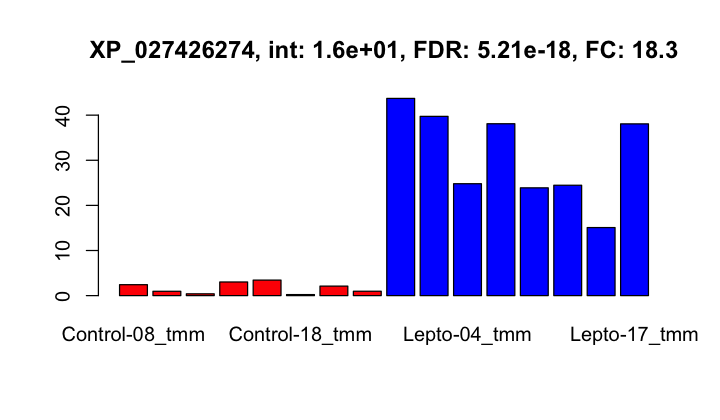

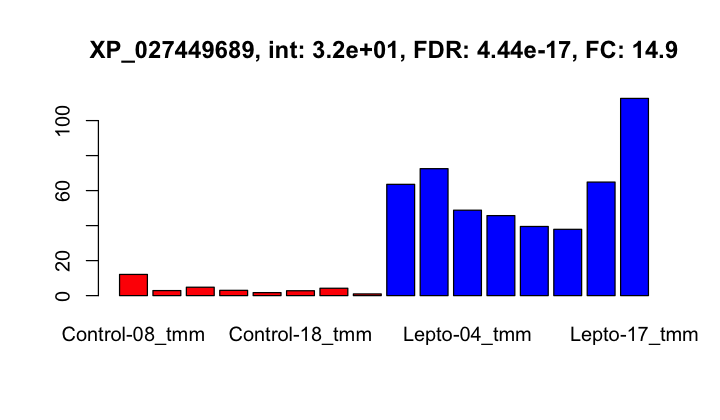

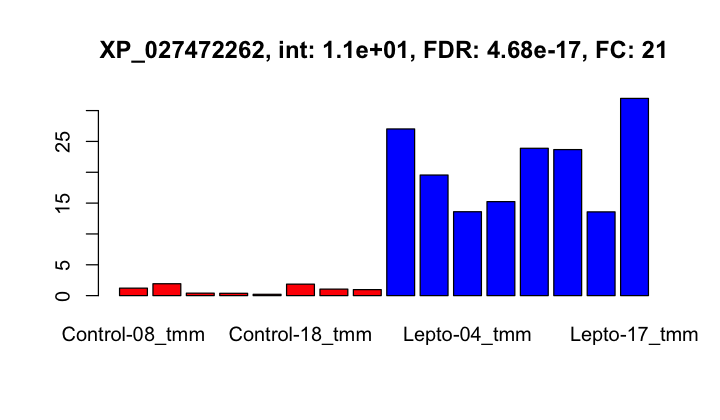

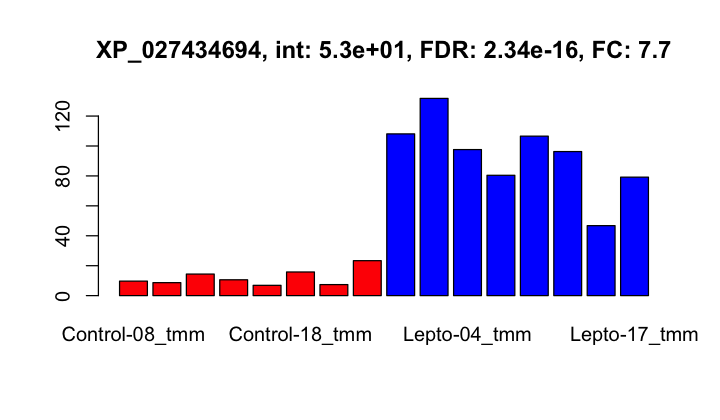

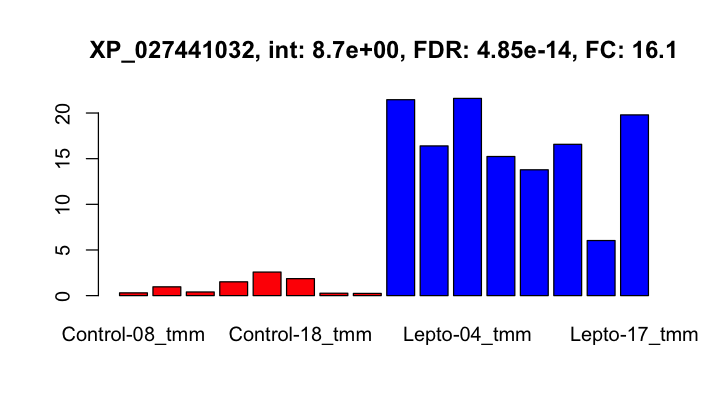

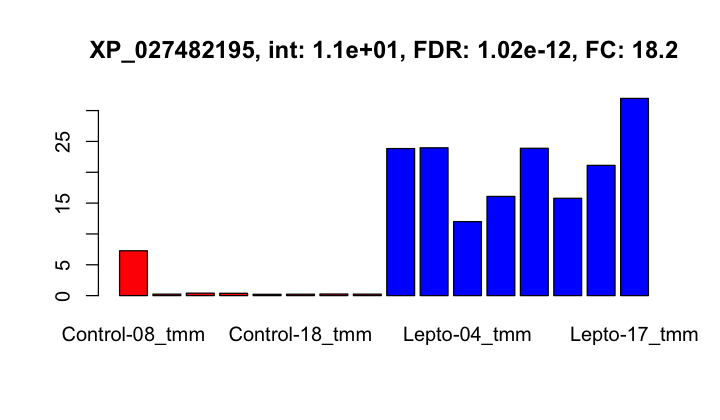

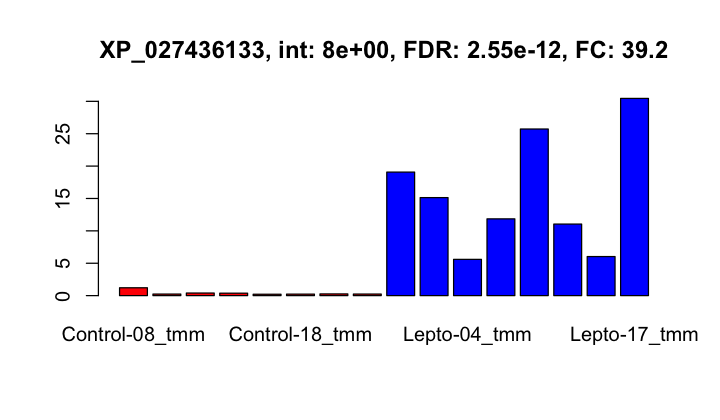

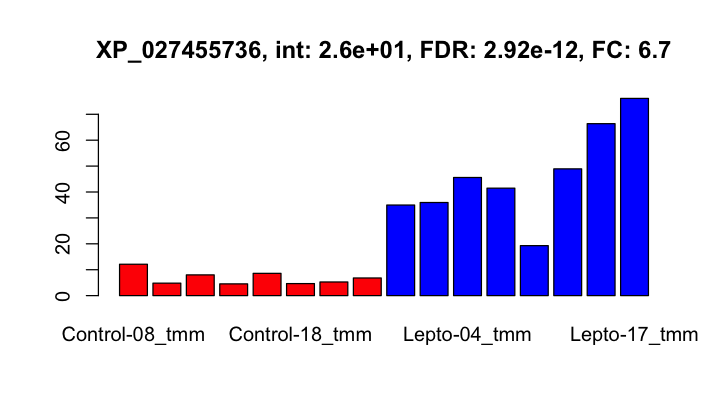

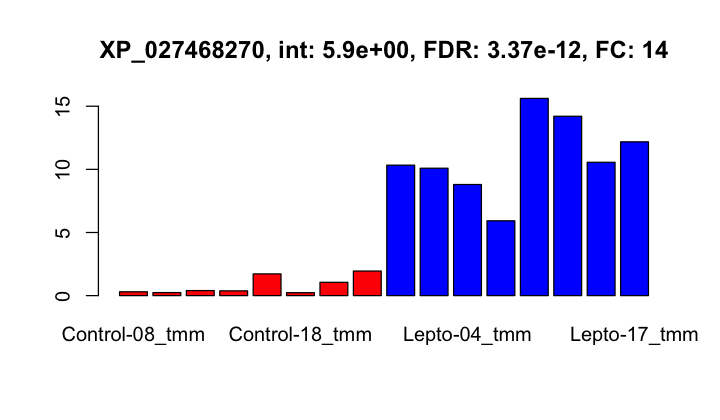

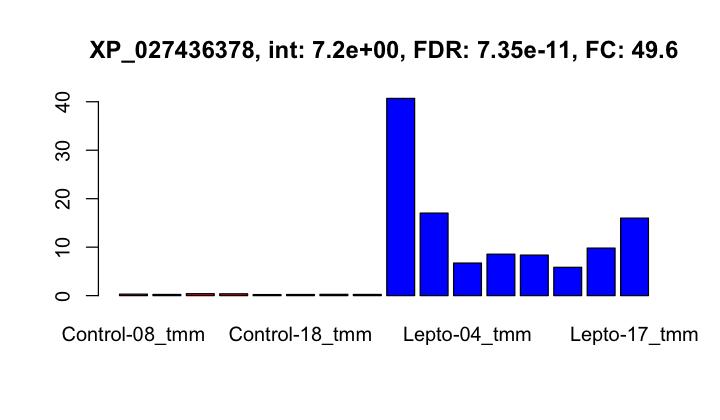

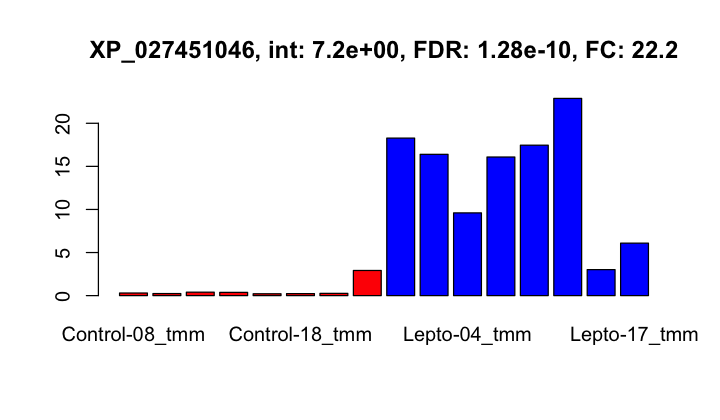

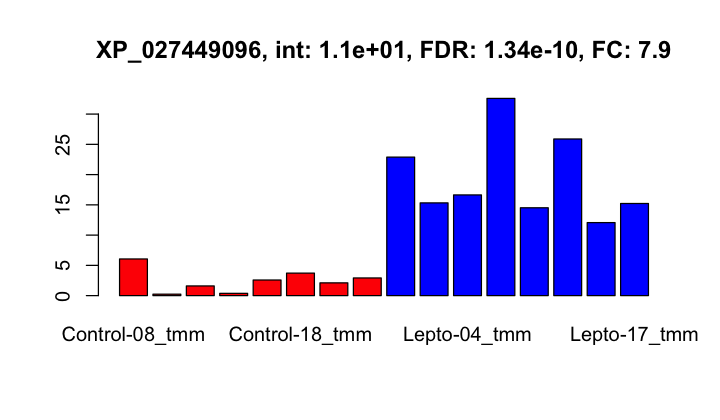

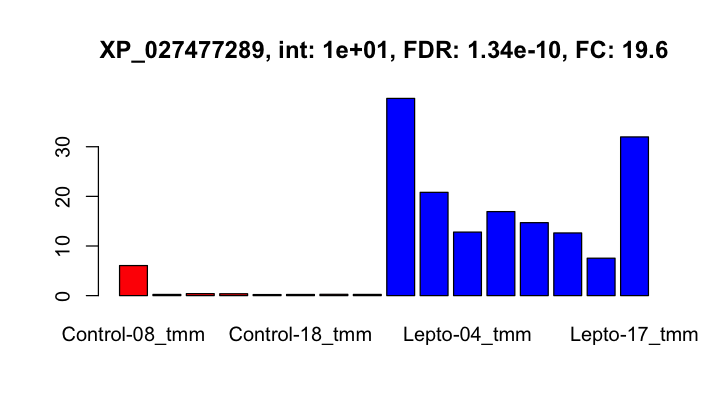

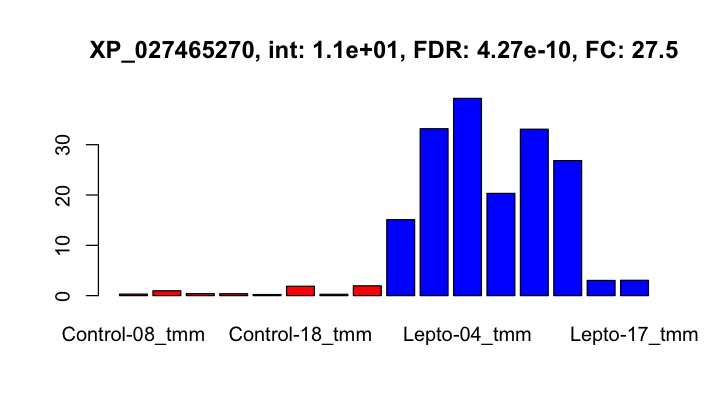

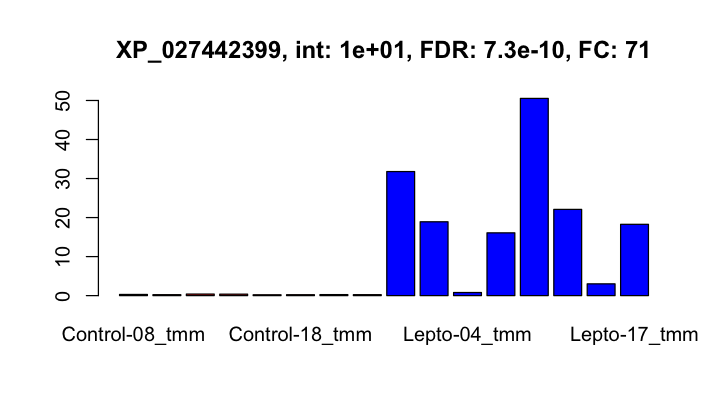

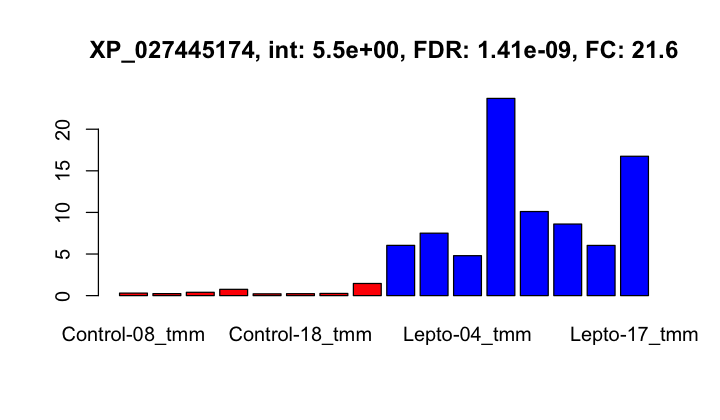

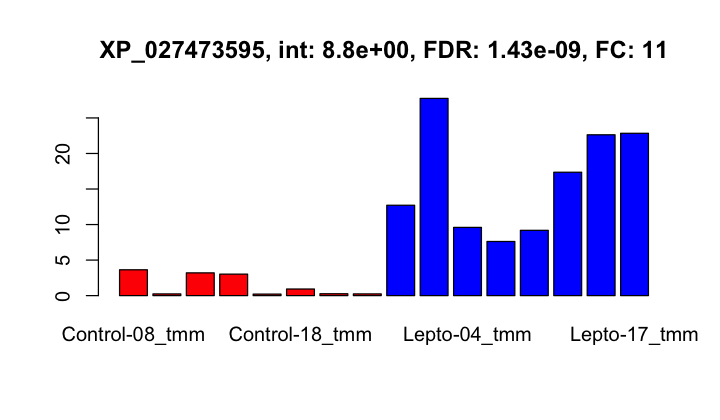

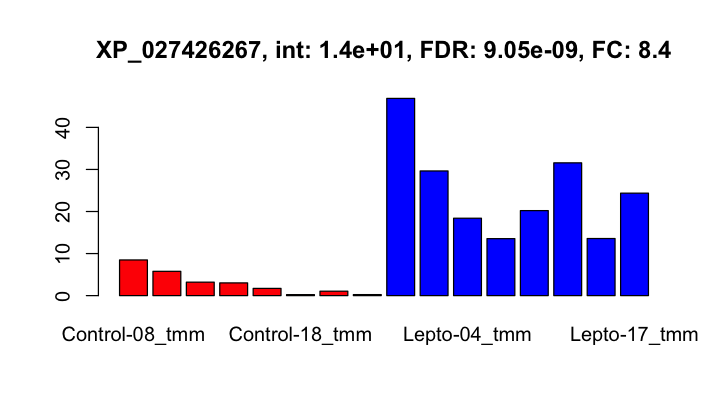

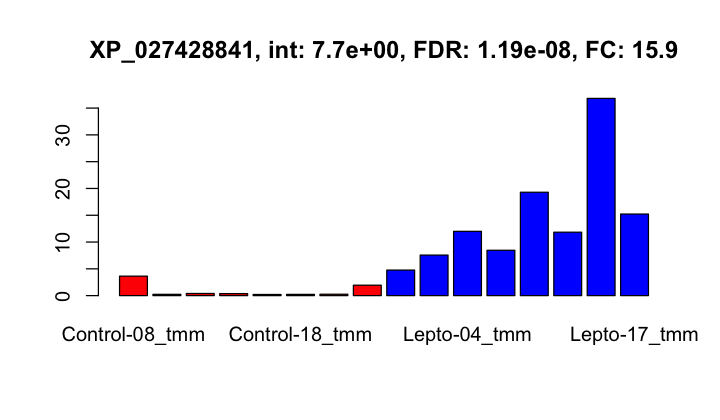

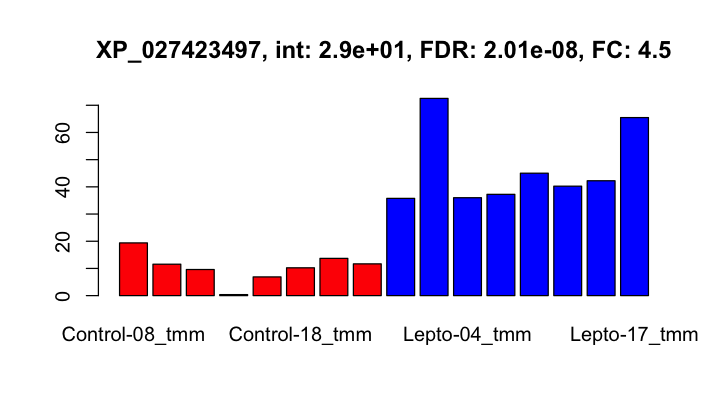

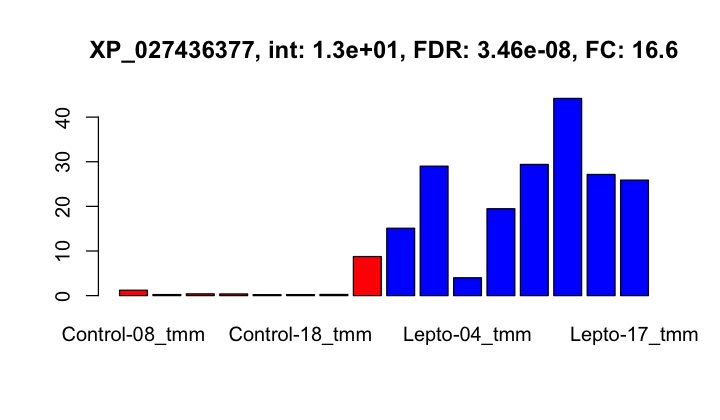

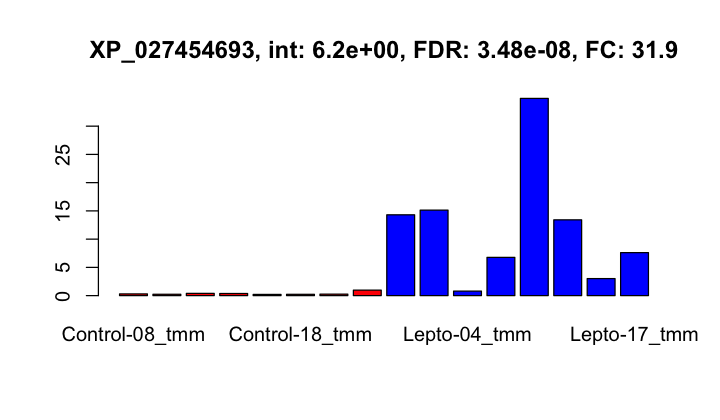

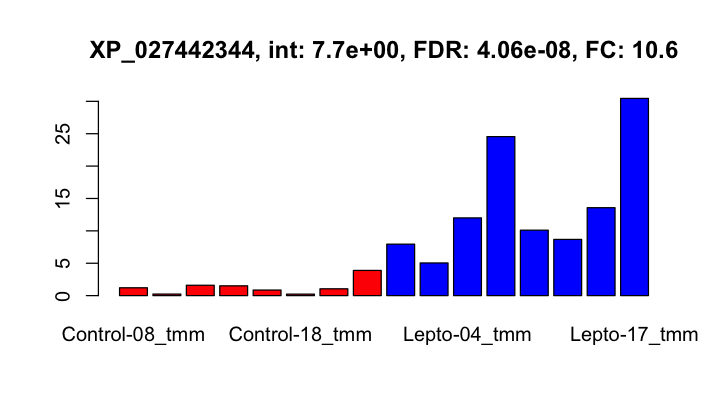

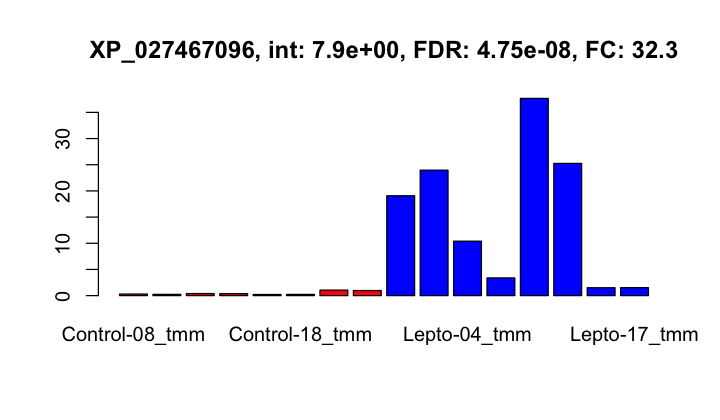

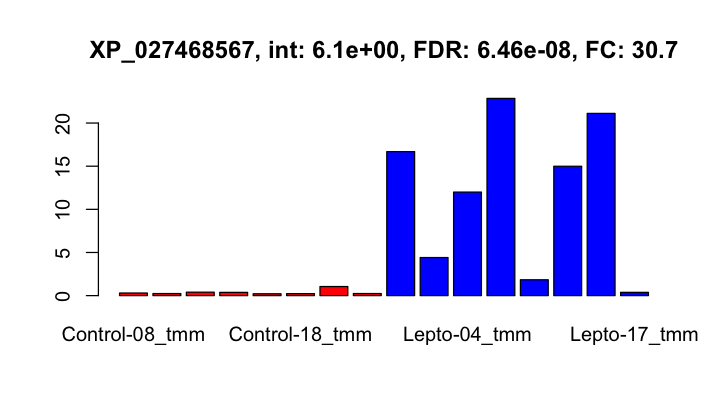

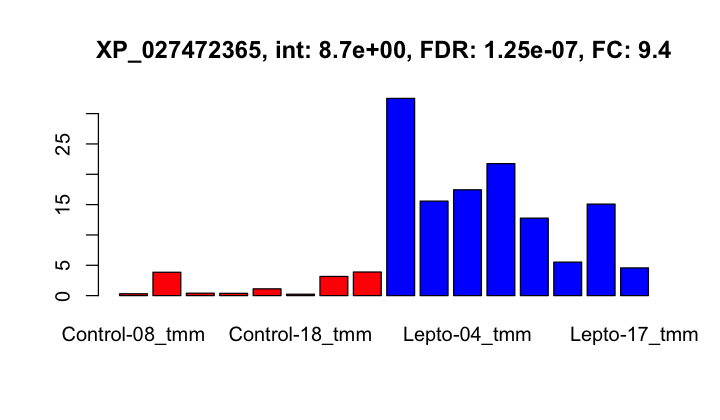

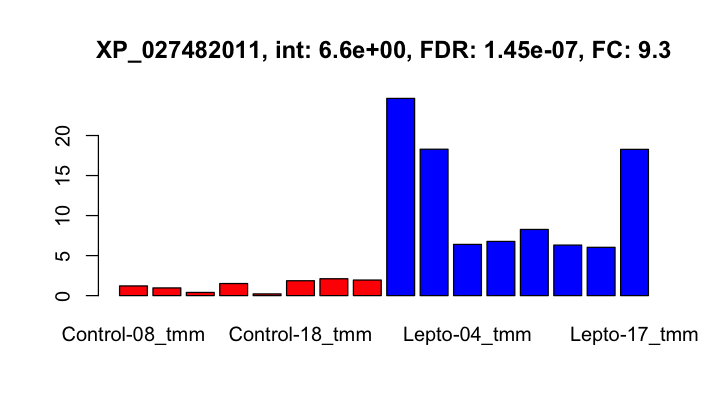

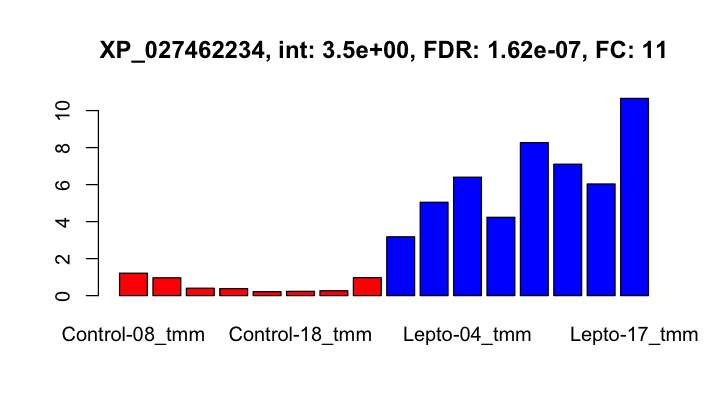

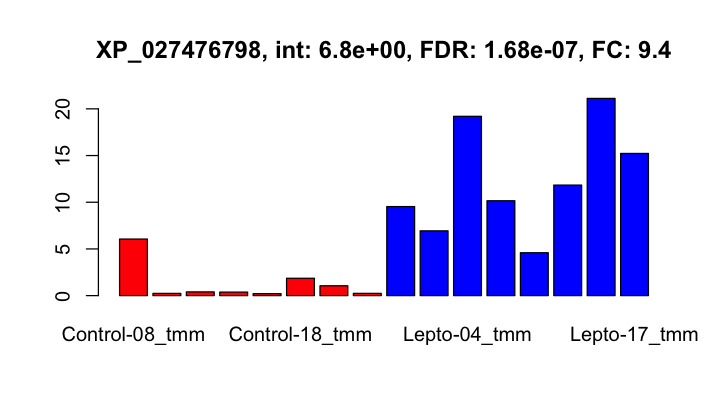

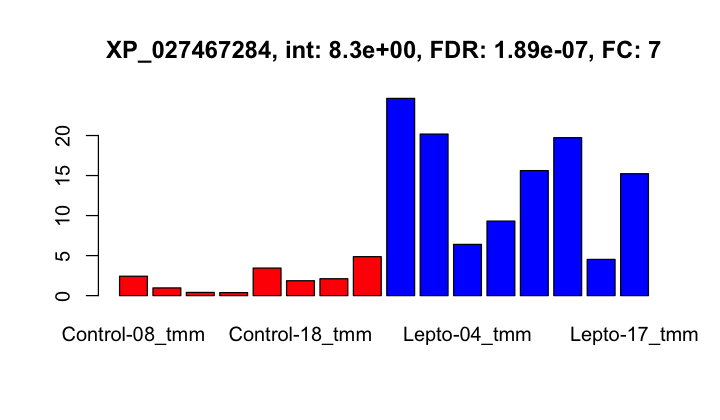

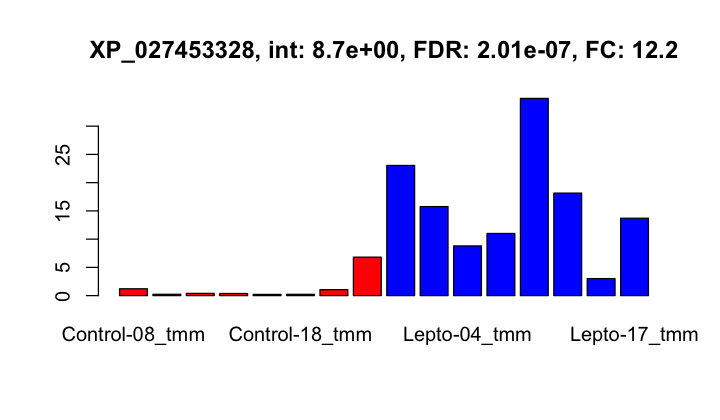

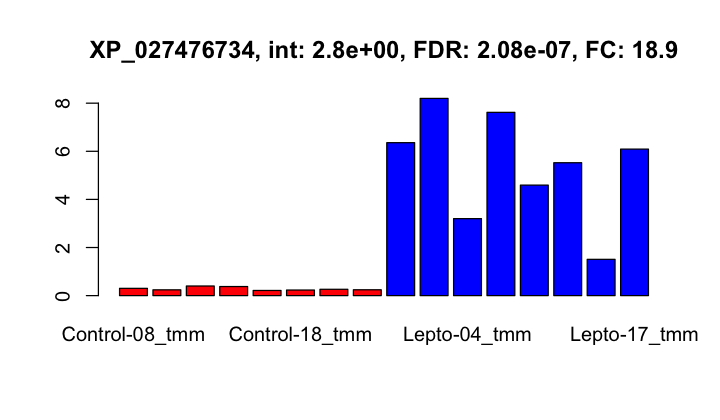

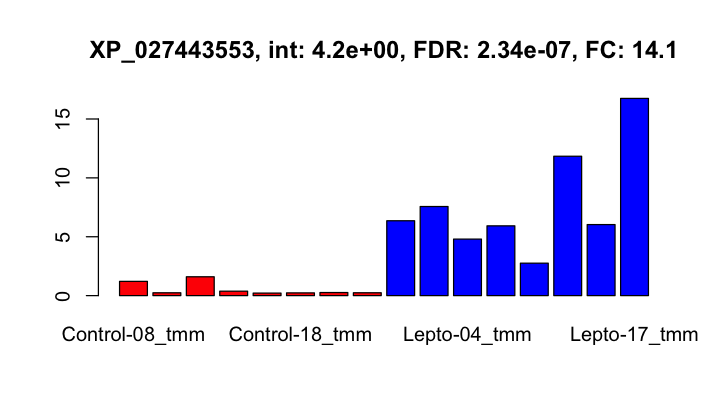

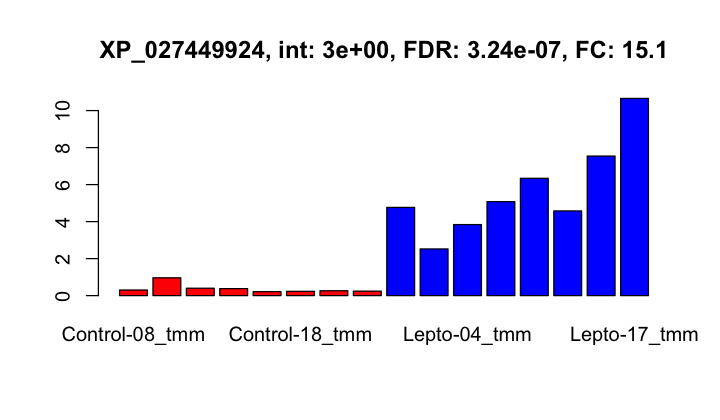

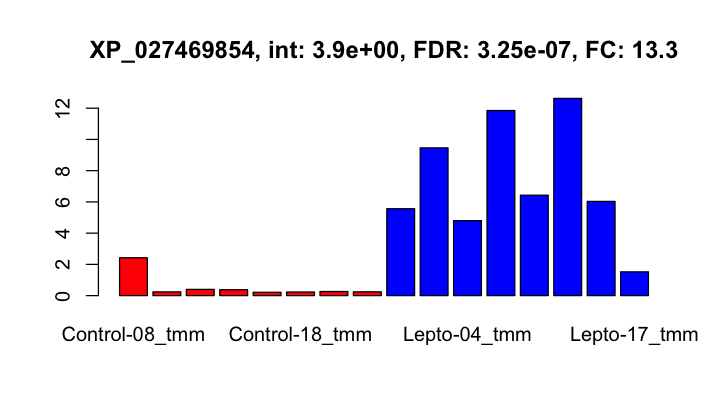

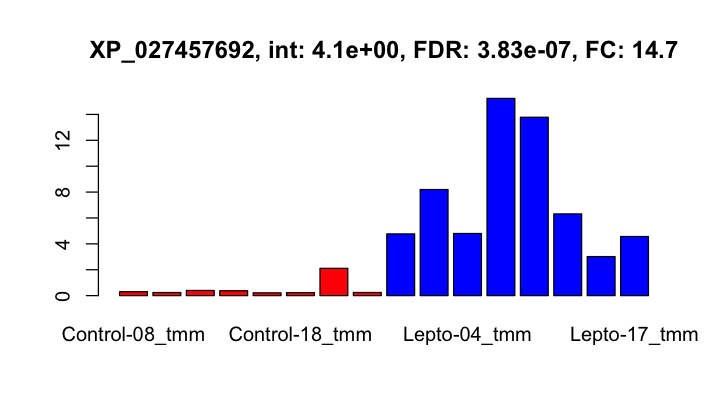

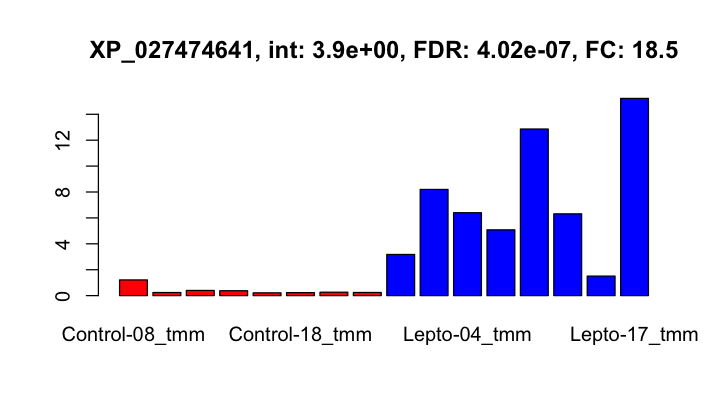

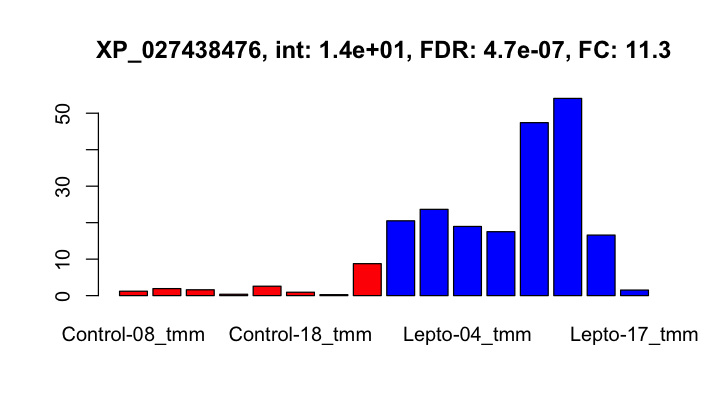

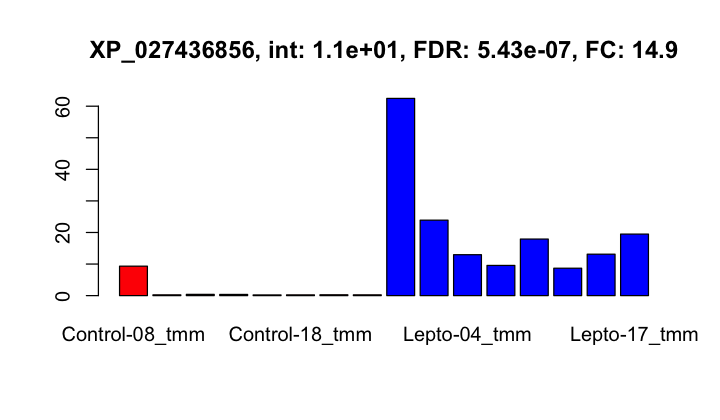

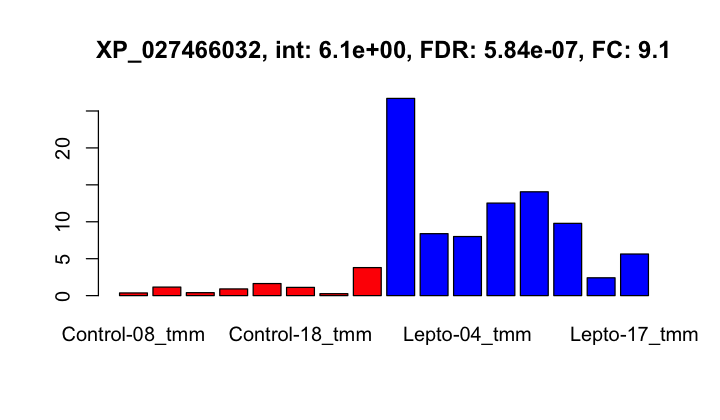

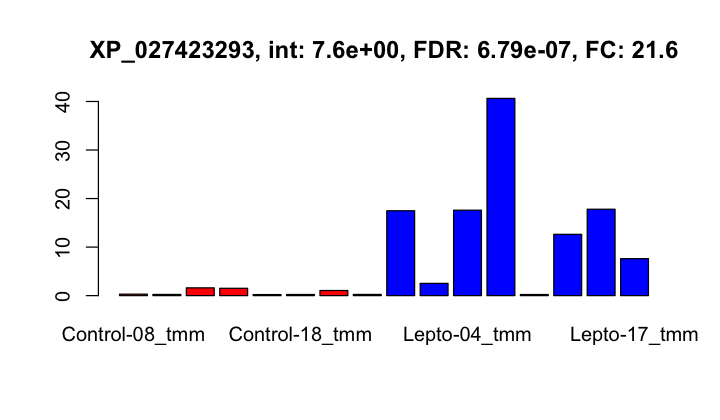

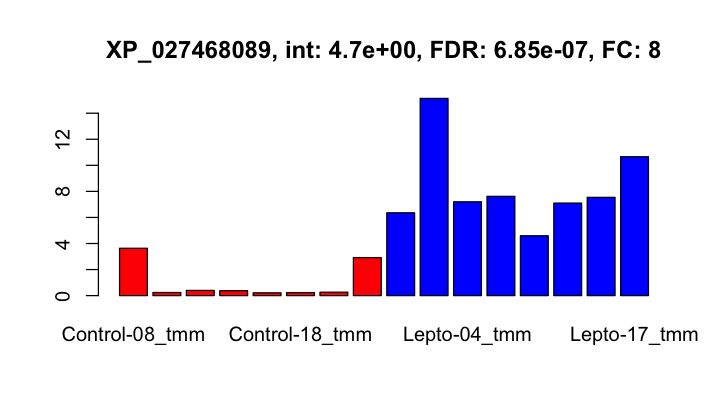

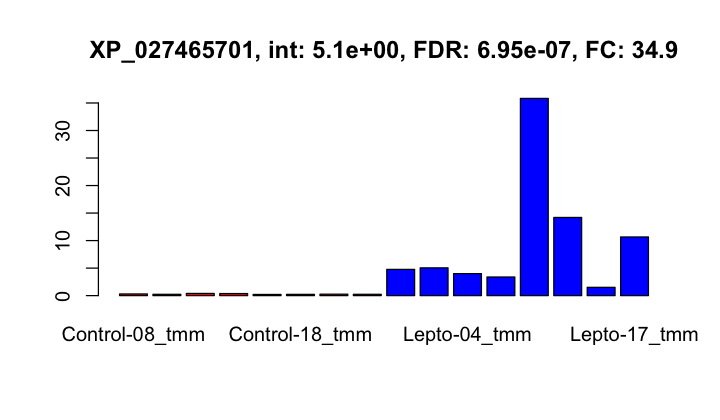

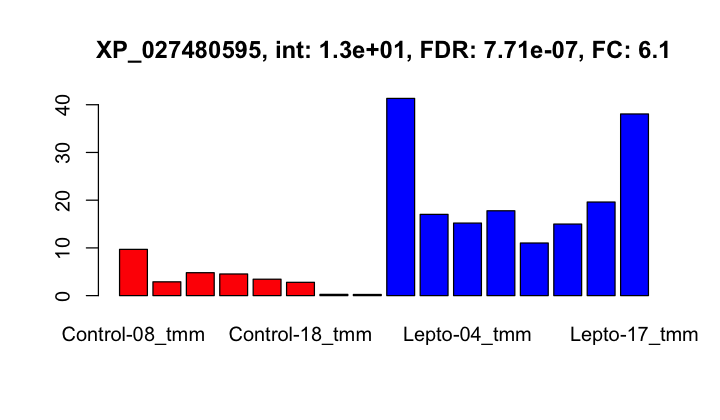

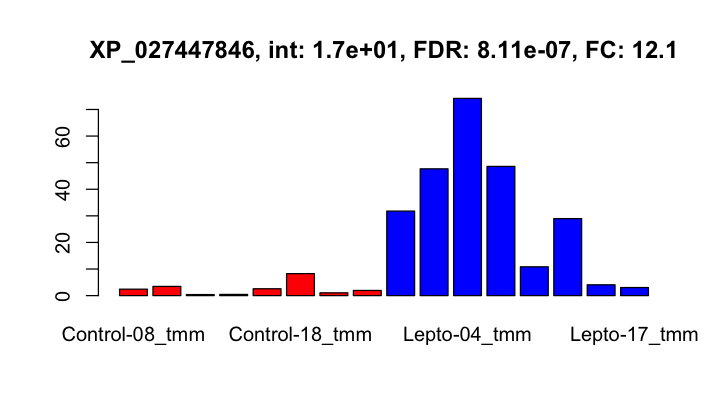

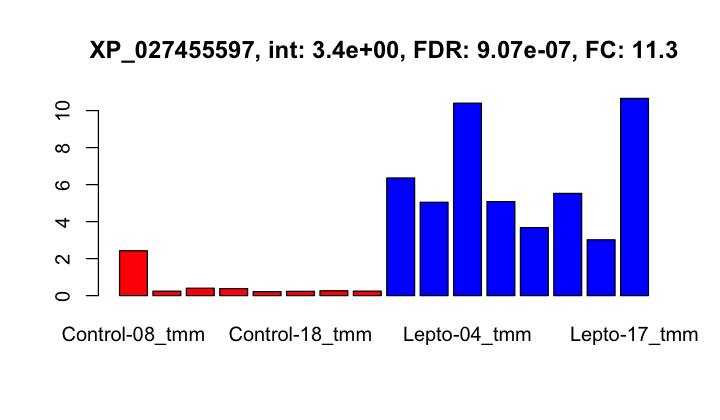

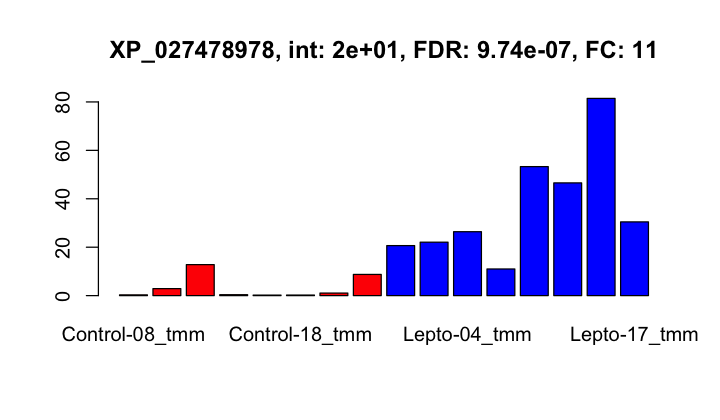

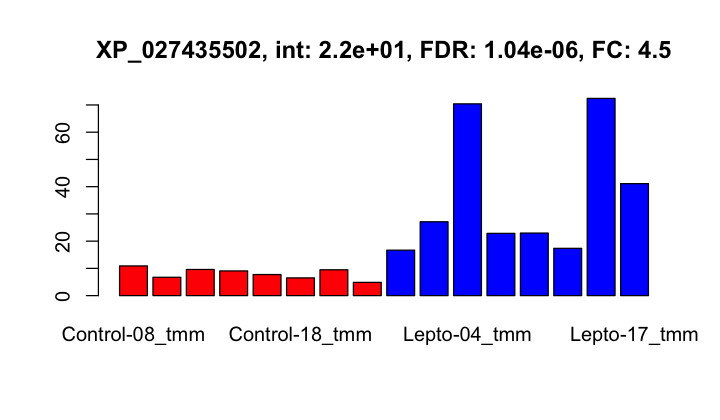

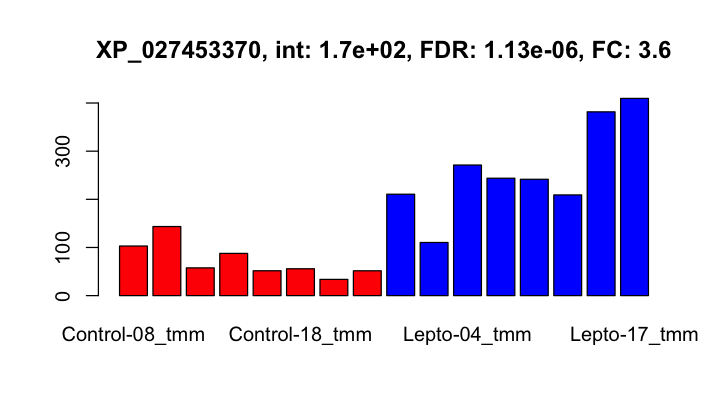

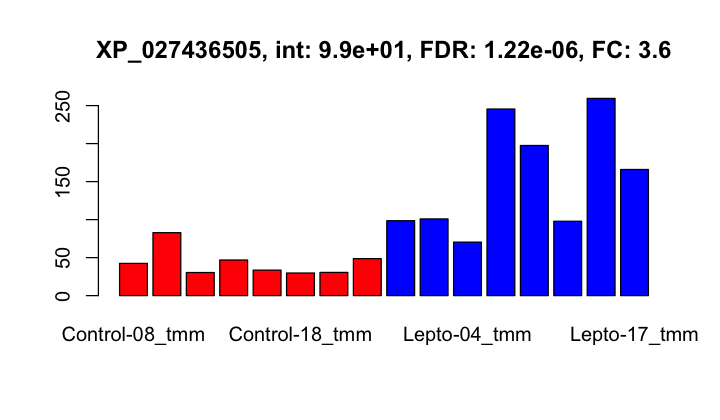

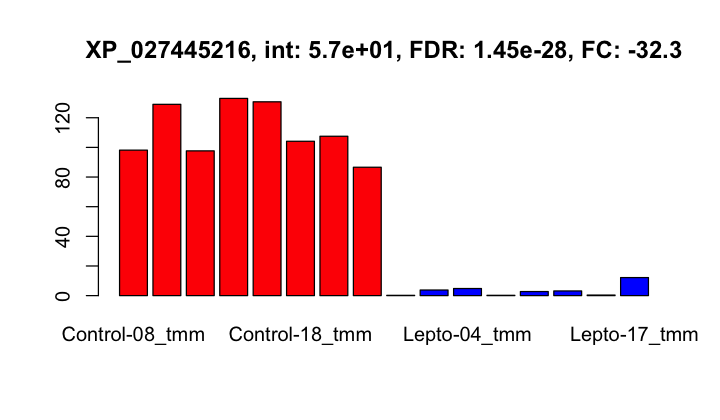

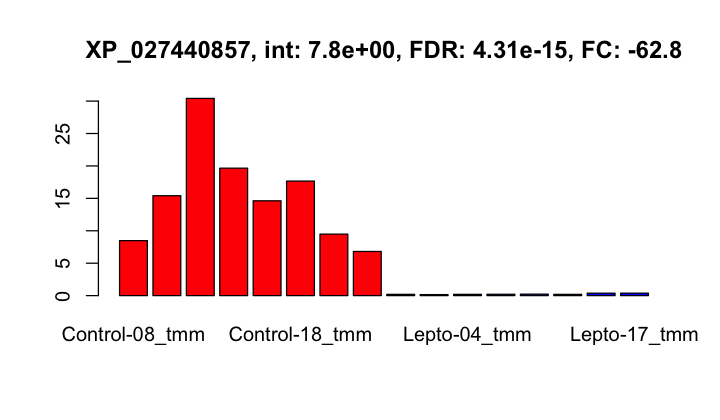

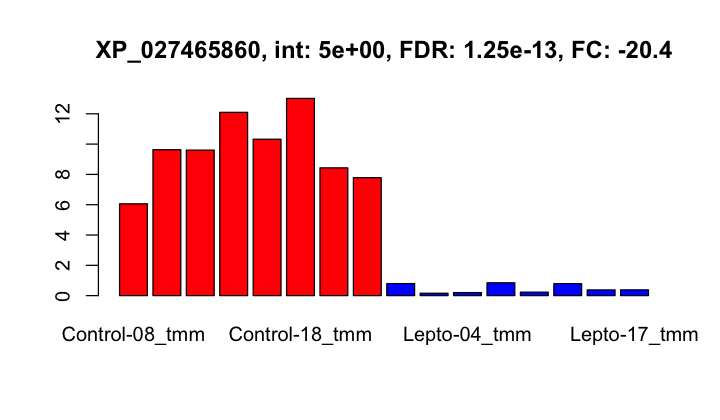

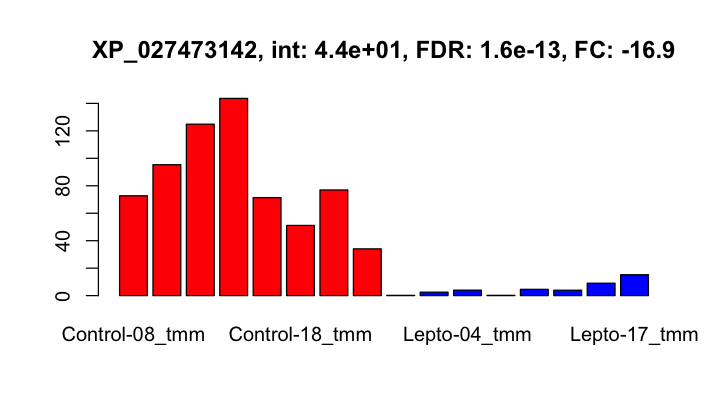

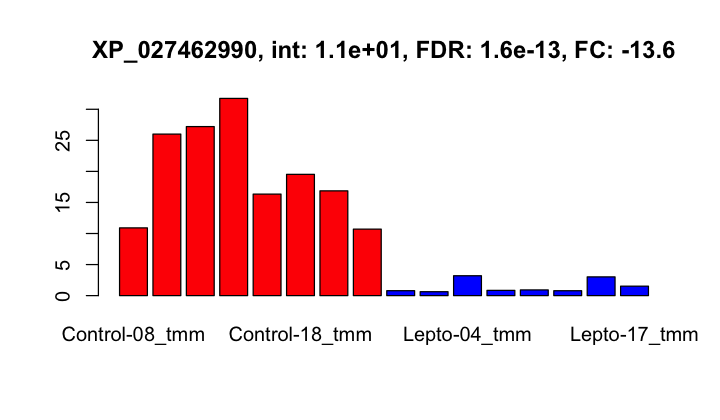

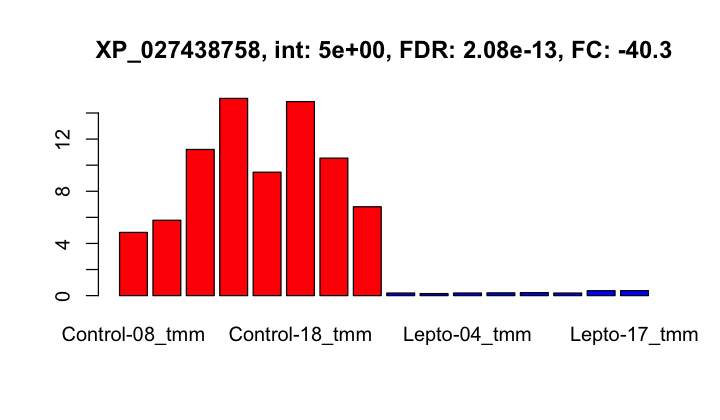

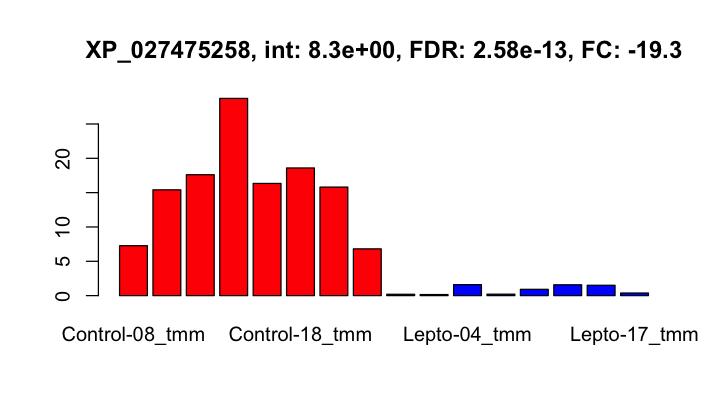

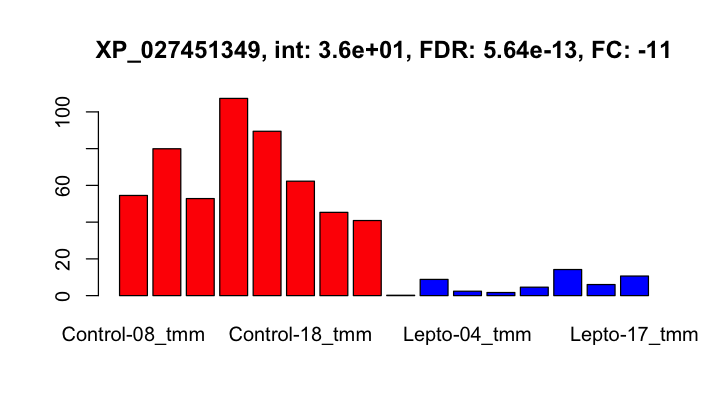

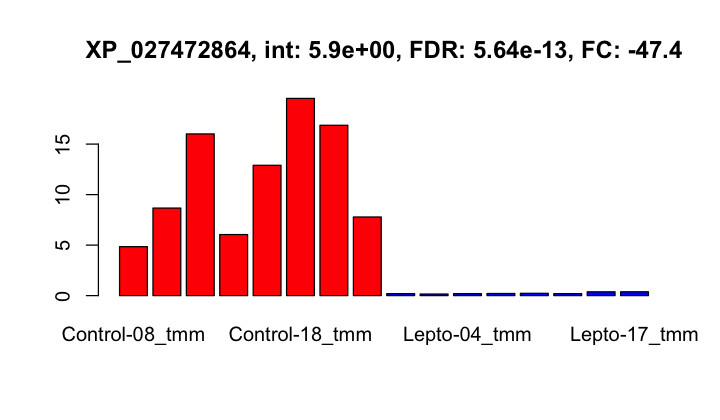

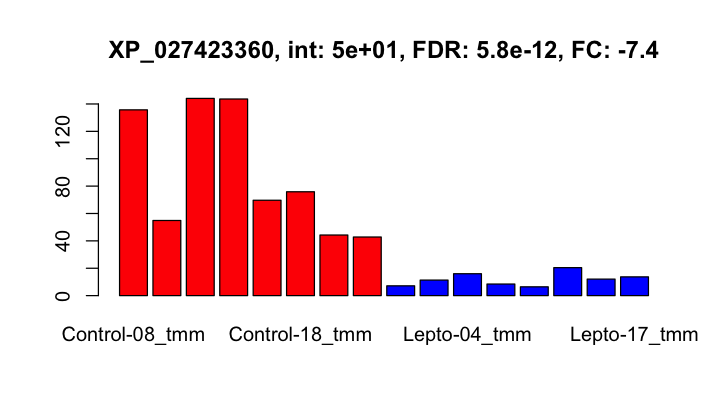

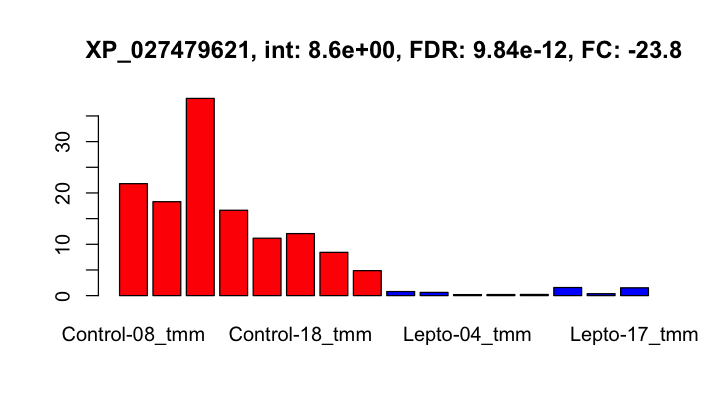

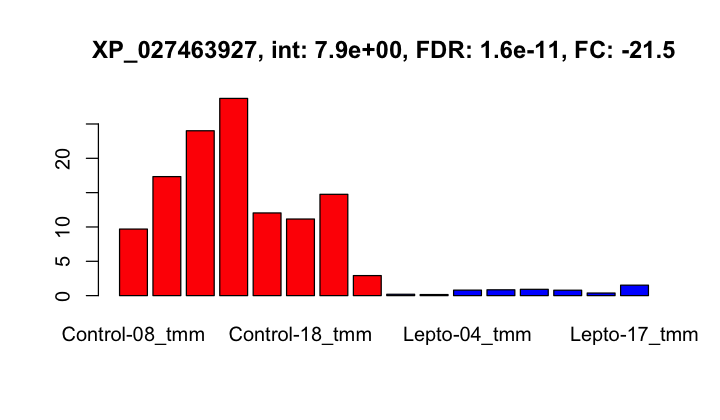

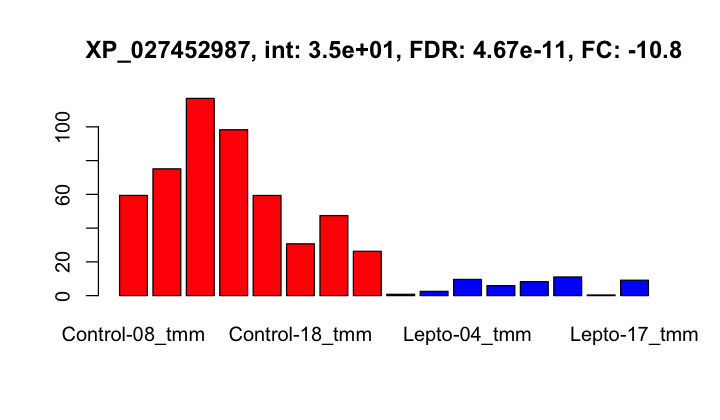

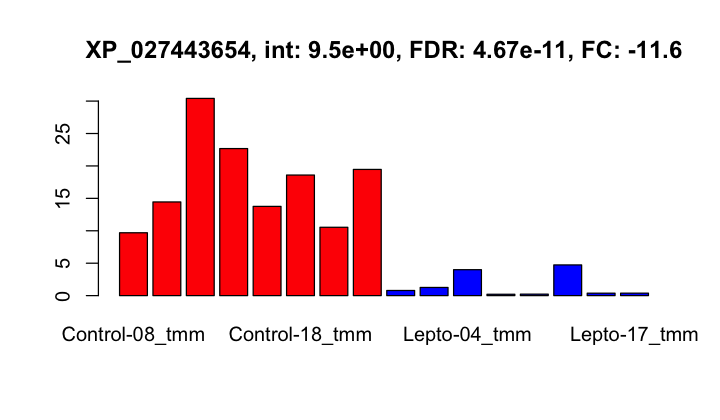

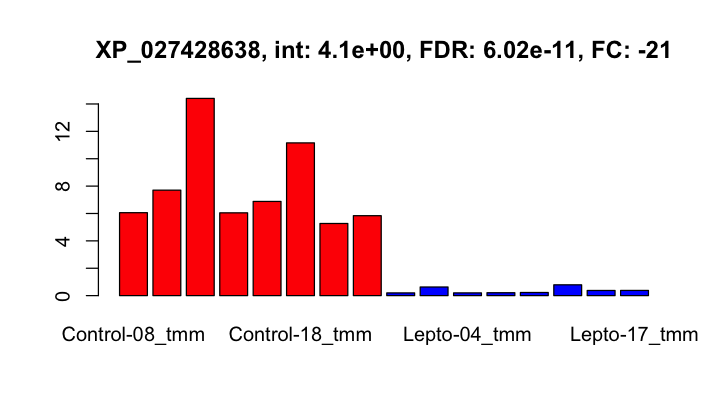

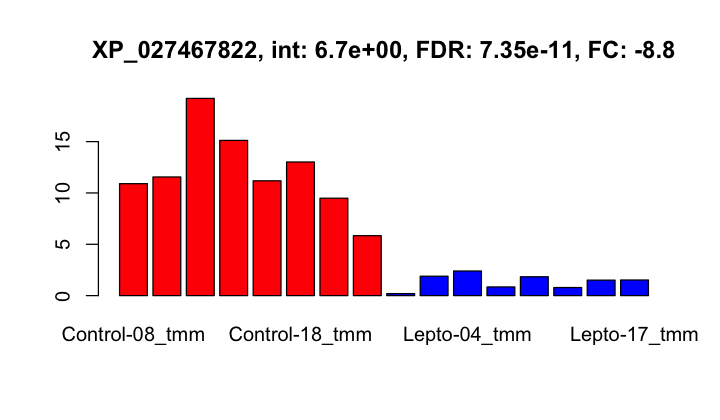

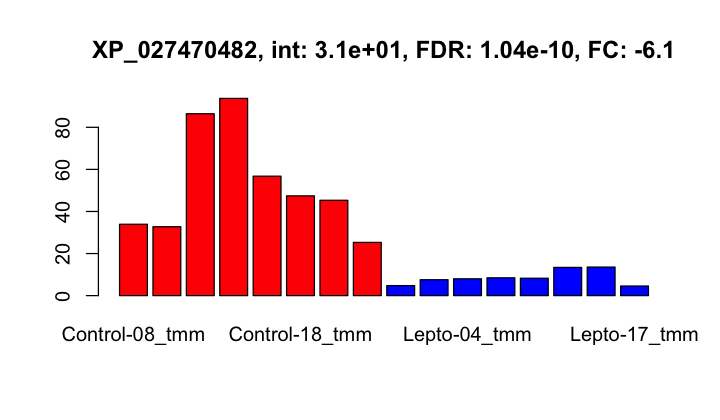

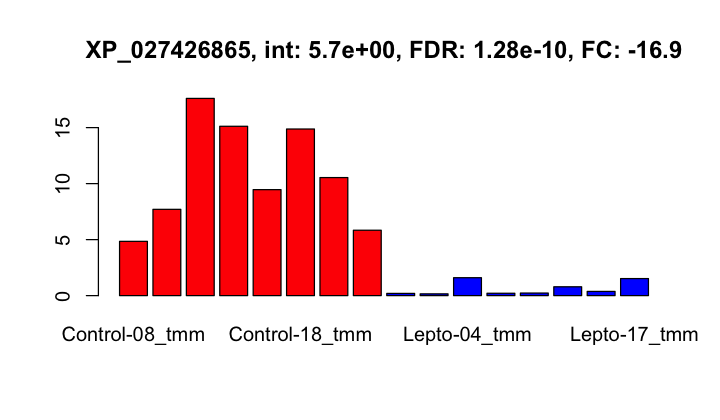

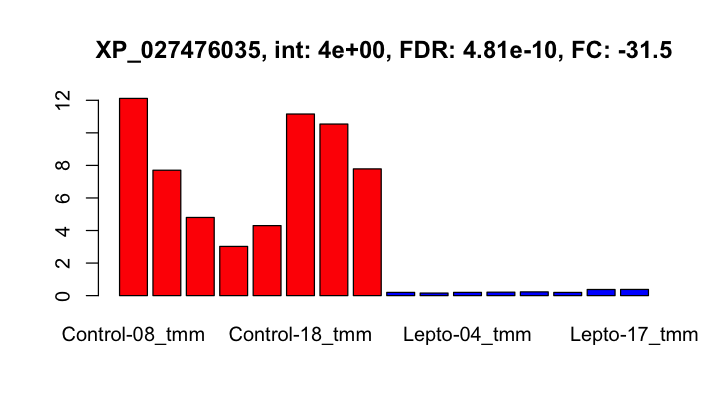

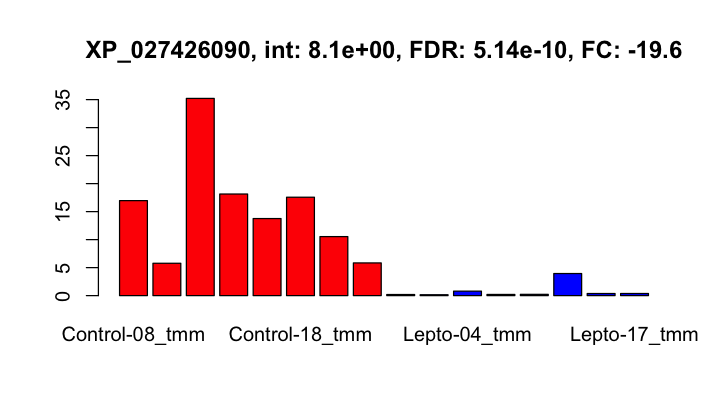

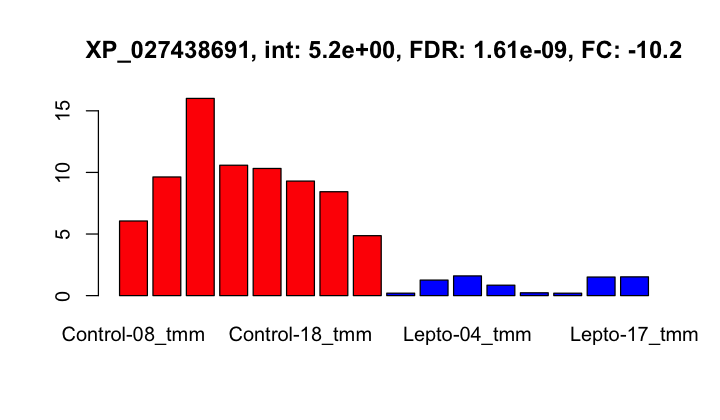

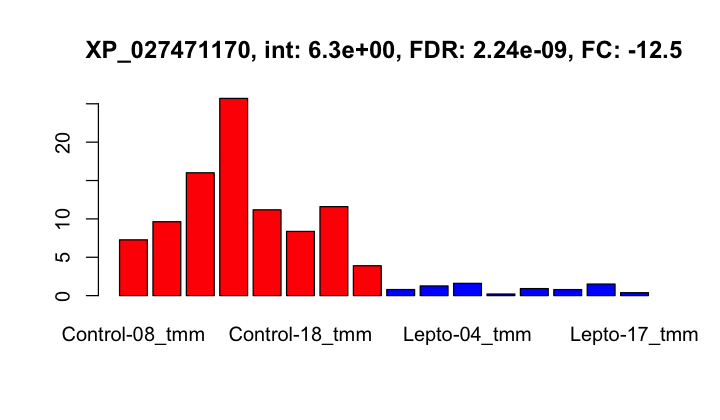

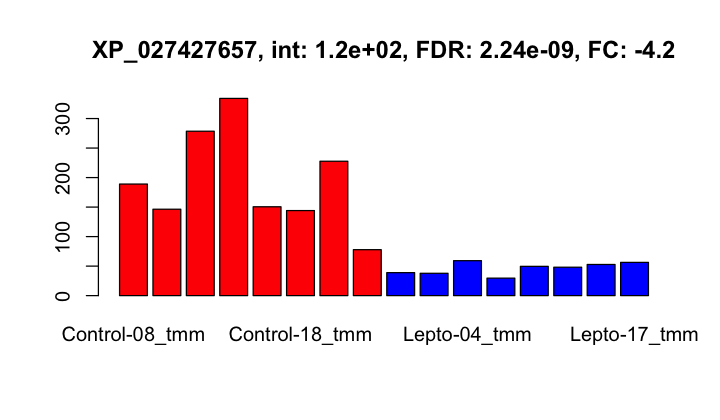

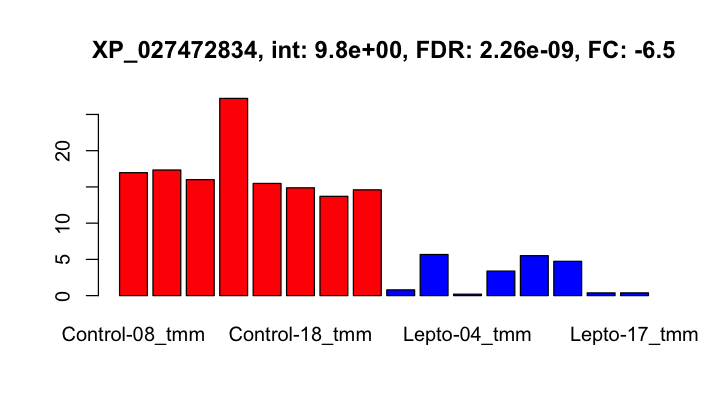

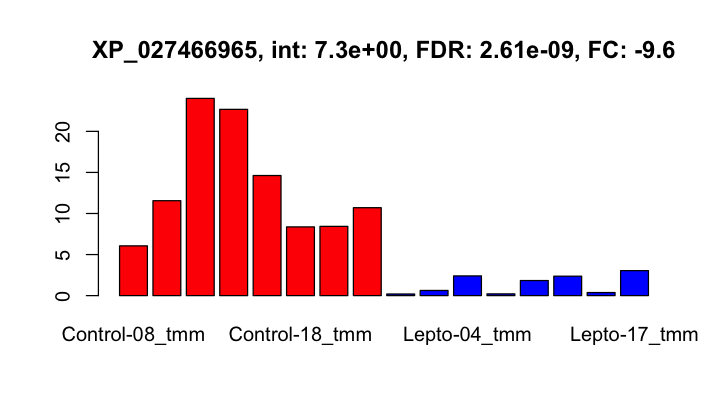

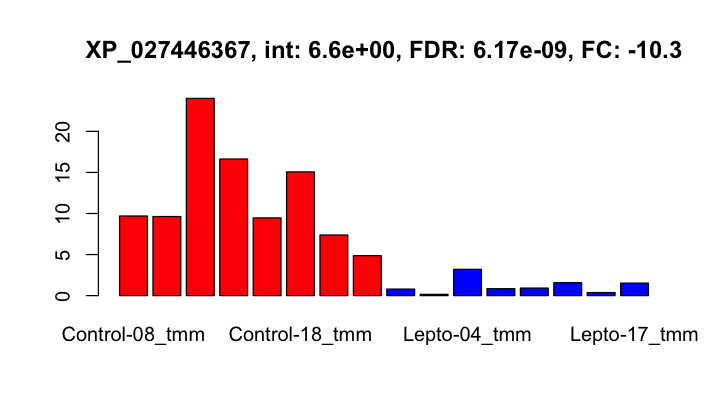

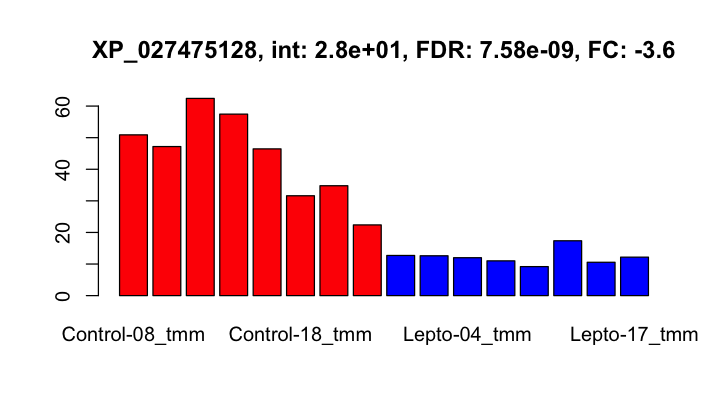

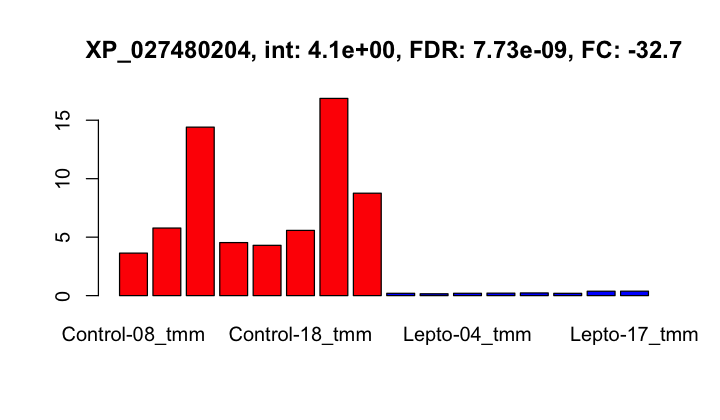

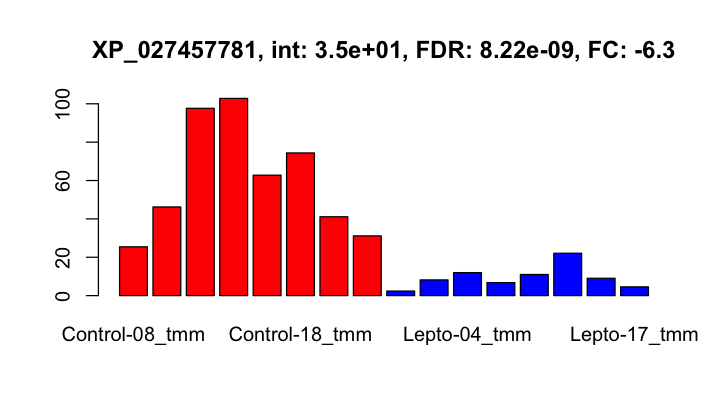

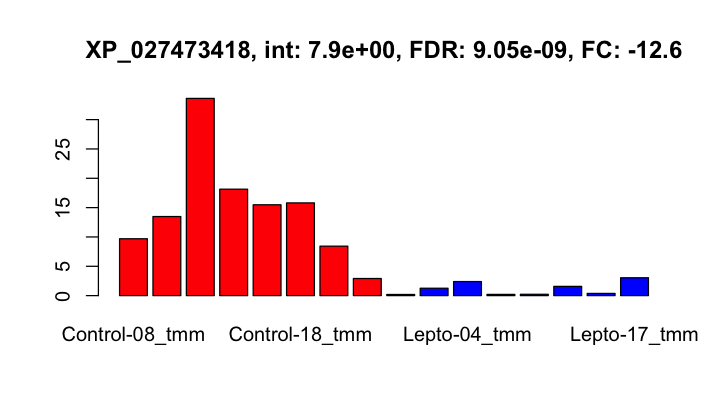

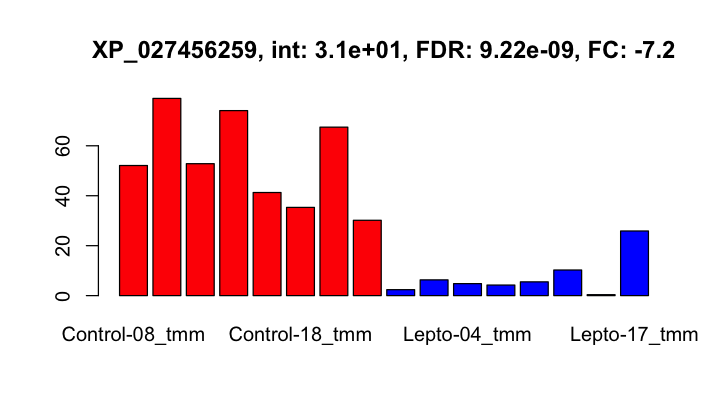

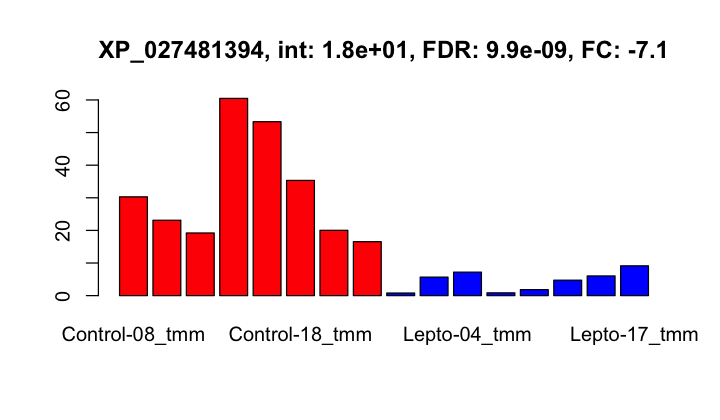

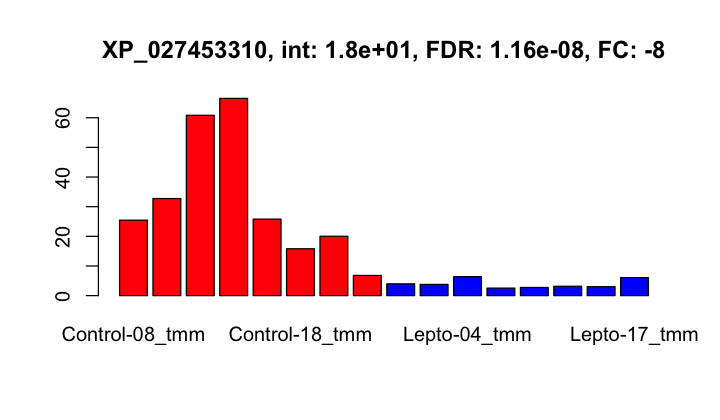

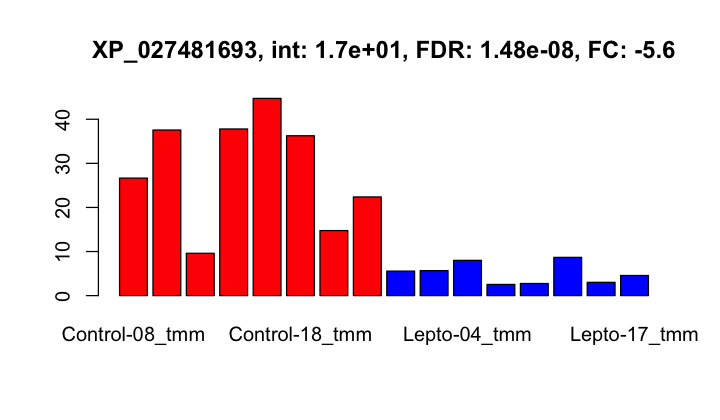

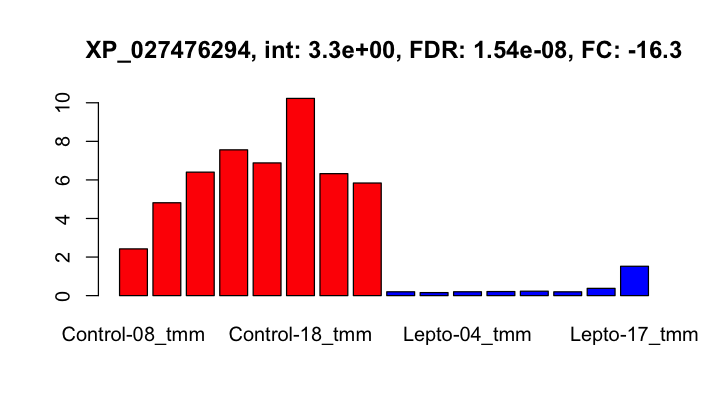

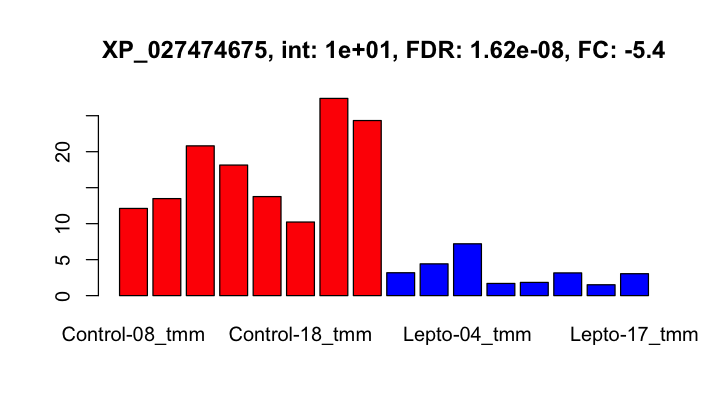

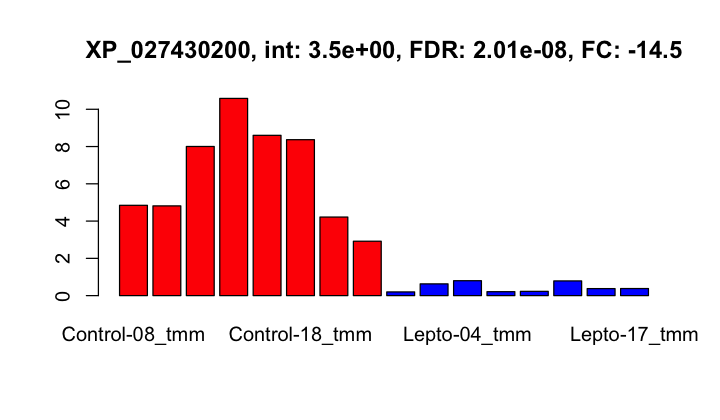

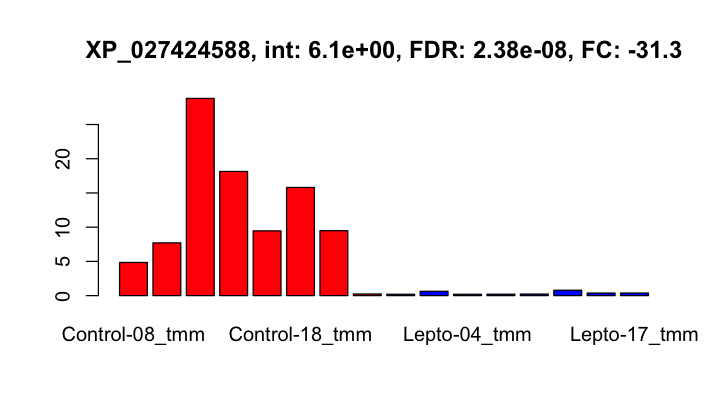

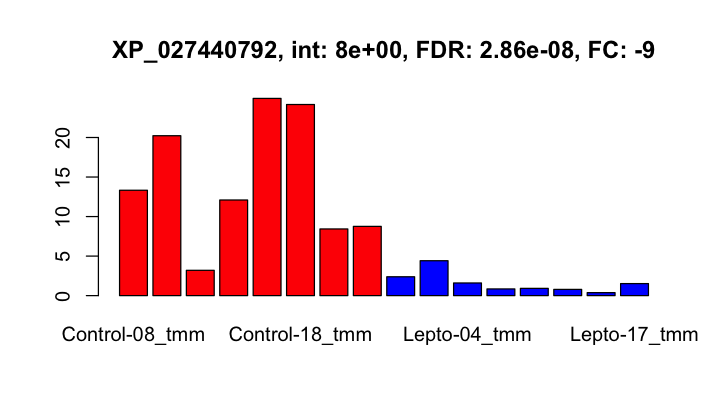

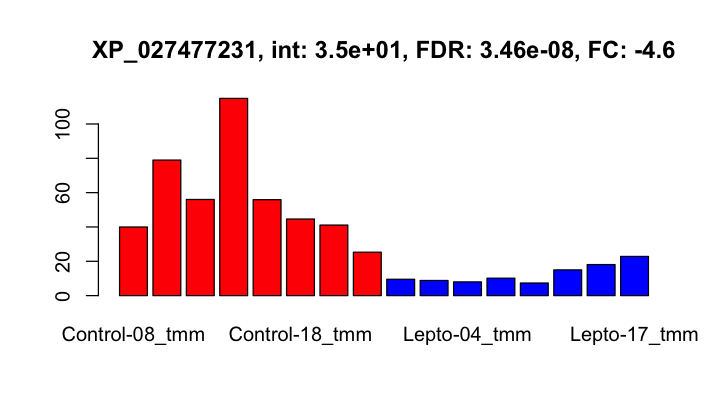

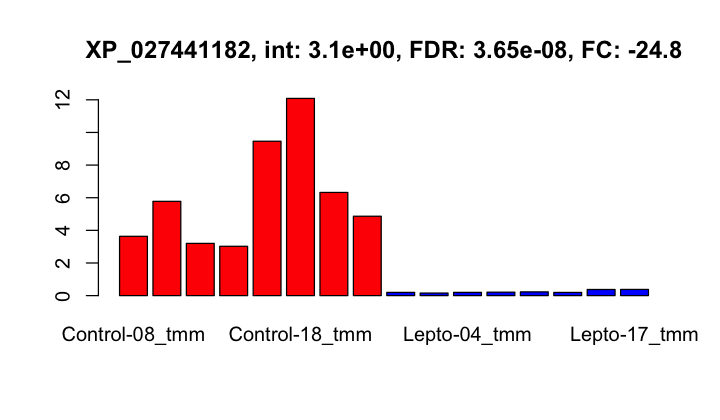

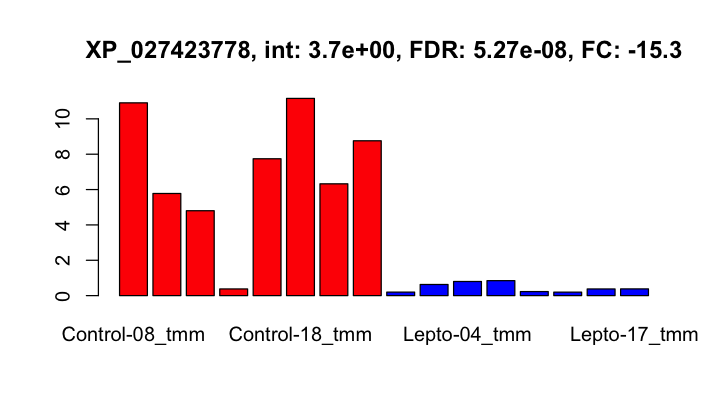

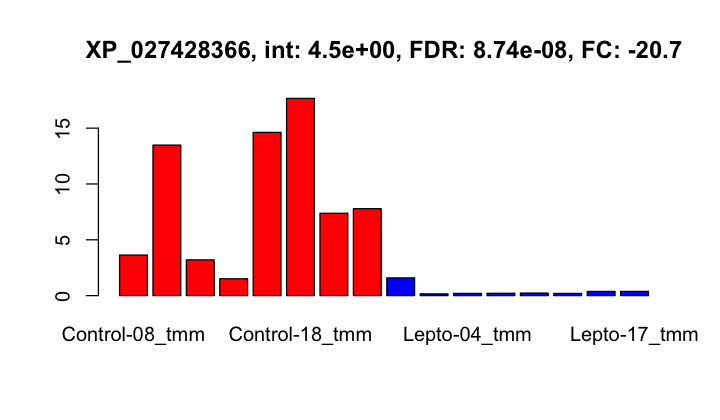

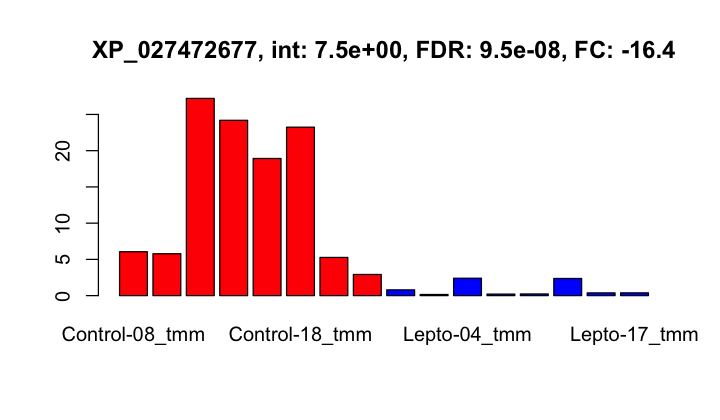

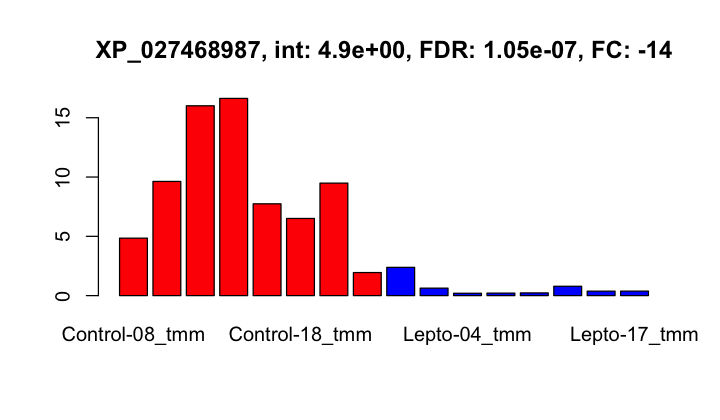

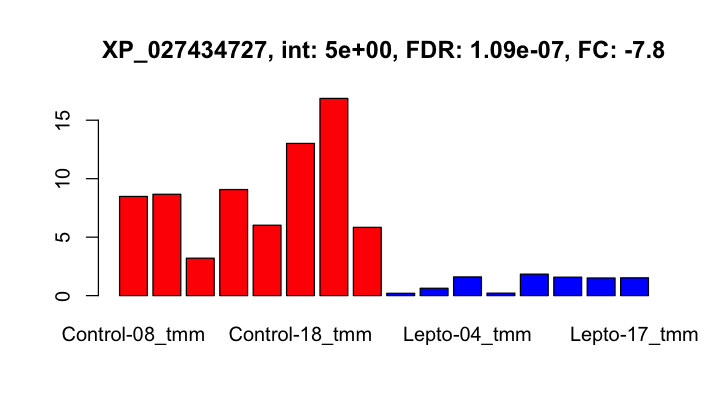

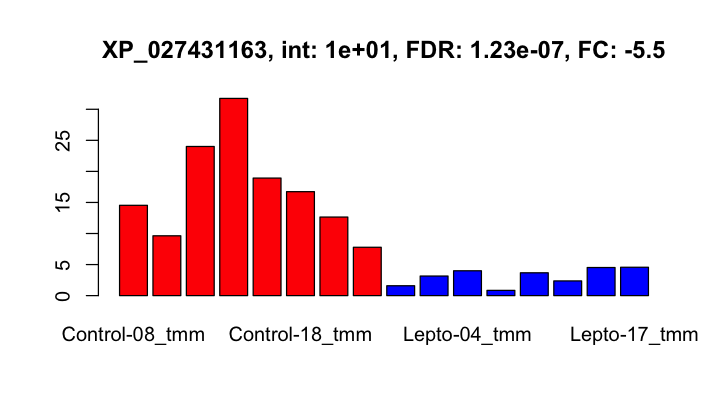

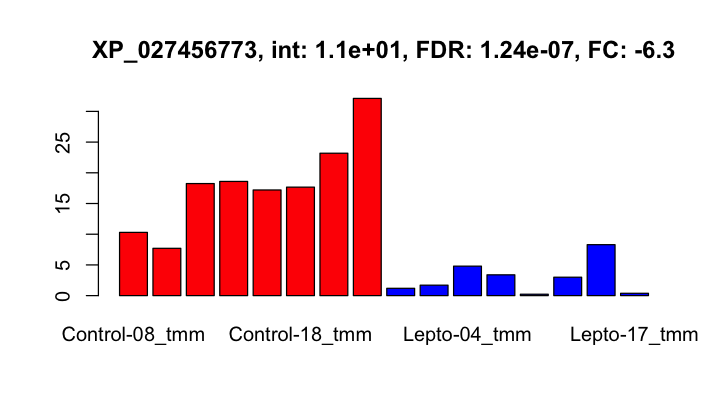

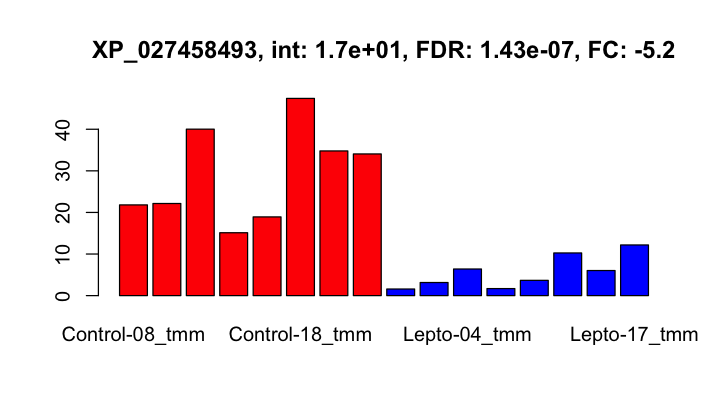

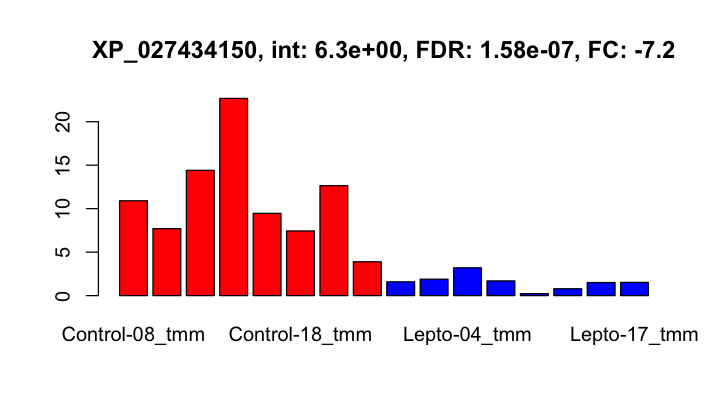

In [33]:
# functions for plotting individual proteins

# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, " |\\.", simplify = TRUE)
    identifier[,1]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_up, top_down) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_up and top_down are number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_up, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_down, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}
# plot the top 50 up and 50 down proteins
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 8, 8, 50, 50)
set_plot_dimensions(7, 7)

## Individual protein plots also look convincing

The top candidates (by B-H adjusted p-values) are pretty convincing looking plots. We will still have to add some annotations to the results file so that we can follow up on these candidates.

## Save the results and log the session

Save results data frame to a disk file and log the R session. Generating the DE candidates is one of the earlier steps in the analysis and interpretation. Adding annotations, functional enrichment analysis, pathway analysis, and more are needed to extract the biological meaning from the data. The results table should be easy to add back to the main proteomics table before the next analysis steps.

In [34]:
# write results
write.table(results, "PXD009019_SpC_results.txt", sep = "\t", row.names = FALSE, na = " ")

# log the session
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.0.0    gridExtra_2.3   psych_1.8.12    edgeR_3.24.3   
 [5] limma_3.38.3    forcats_0.4.0   stringr_1.4.0   dplyr_0.8.1    
 [9] purrr_0.3.2     readr_1.3.1     tidyr_0.8.3     tibble_2.1.1   
[13] ggplot2_3.1.1   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 locfit_1.5-9.1   repr_1.0.1      
 [5] splines_3.5.3    haven_2.1.0      lattice_0.20-38  vctrs_0.1.0     
 [9] colorspace_1.4-1 generics_0.0.2   htmltools_0.3.6  base64en